<a href="https://colab.research.google.com/github/XenoicZ/EPE/blob/main/PFN_MDN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PFN and PFN with mdn layer
this note book is only for model training, see result comparison in PFN_eval.ipynb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time as t
import scipy.constants as spc
import matplotlib.ticker as ticker
import os

In [3]:
path_prefix = '/content/drive/MyDrive/ml4pion/'
plotpath = path_prefix+'plots/'
modelpath_c = path_prefix+''
modelpath = path_prefix+''
ext_path = "/content/drive/MyDrive/ml4pion/"
ext_modelpath = ext_path + "model/"
ext_datapath = '/content/drive/MyDrive/ml4pion/ML4Pion/PFNet/numpy_files/'
ext_plotpath = ext_path + "plots/"

In [4]:
!pip install atlas_mpl_style
!pip install uproot3
!pip install energyflow
import energyflow as ef
from energyflow.archs import PFN
import sys
sys.path.append(path_prefix)
from util import resolution_util as ru
from util import resolution_util_modified as rum
from util import plot_util as pu
from util import ml_util as mu
import uproot3 as ur
import keras.utils.io_utils as kiu
import h5py as h5
import tensorflow as tf
import scipy.stats as stats

# MDN usage
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model
from scipy import interpolate
import keras.backend as Kb
import tensorflow_probability as tfp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 4.1 MB/s 
     |████████████████████████████████| 87 kB 6.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 700 kB 4.3 MB/s 
     |████████████████████████████████| 427 kB 65.2 MB/s 


In [69]:
def tvt_num(_data, _tvt=(75, 10, 15)):
    ''' Function designed to output appropriate numbers for traning validation and testing given
    a variable length input. TVT expressed as ratios and do not need to add to 100. '''
    _tot = len(_data)
    _train, _val, _test = _tvt
    _tvt_sum = _train + _val + _test
    
    _train_rtrn = round(_train*_tot/_tvt_sum)
    _val_rtrn = round(_val*_tot/_tvt_sum)
    _test_rtrn = _tot - _train_rtrn - _val_rtrn
    
    return _train_rtrn, _val_rtrn, _test_rtrn

def _iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q16, q84 = np.percentile(x, [16, 84])
    return (q84 - q16) / (2 * np.median(x))

def resolutionPlot(x, y, figfile='',
                   xlabel='True Energy [GeV]', ylabel='Response IQR / (2 x Median)',
                   atlas_x=-1, atlas_y=-1, simulation=False,
                   xlim=(0.3,1000), ylim=(0,1),
                   x_step=0.05, 
                   textlist=[]):
    xbin = [10**exp for exp in  np.arange(-1.0, 3.1, x_step)]
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

    resolution = stats.binned_statistic(x, y, bins=xbin, statistic=_iqrOverMed).statistic
    
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(xcenter, resolution)
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, resolution


def eval_generator(data, batch_size):
     batches = (len(data) + batch_size - 1)//batch_size
     for i in range(batches):
          X = data[i*batch_size : (i+1)*batch_size]
          yield (X)

def eval_cal(X, batch_size, model):
    mean = []
    std = []
    for i in range(0, X.shape[0], batch_size):
        yhat = model(X[i:i+batch_size,:,:])
        assert isinstance(yhat, tfp.distributions.Distribution)
        yhat_cw = yhat.submodules[1].probs_parameter().numpy()
        weight_mask = yhat_cw.max(axis=1, keepdims=True) ==  yhat_cw
        yhat_means = yhat.submodules[3].mean().numpy()
        pred_mean = yhat_means[weight_mask].flatten()
        yhat_stddev = yhat.submodules[3].stddev().numpy()
        pred_std = yhat_stddev[weight_mask].flatten()
        mean.append(pred_mean)
        std.append(pred_std)
    return np.concatenate(mean), np.concatenate(std)


def tol_mean(weight, mu):
  # total mean of 3 Gaussian mixtures
  sum = weight * mu
  return np.sum(sum, axis=1)


def tol_var(weight, mu, sigma):
  # total variance of 3 Gaussian mixtures
  # https://stats.stackexchange.com/questions/16608/what-is-the-variance-of-the-weighted-mixture-of-two-gaussians
  sum_1 = np.sum(weight * sigma**2, axis=1)
  sum_2 = np.sum(weight * mu**2, axis=1)
  sum_3 = np.sum(weight * mu, axis=1)**2
  return sum_1 + sum_2 - sum_3

def tol_std(weight, mu, sigma):
  sum_1 = np.sum(weight * sigma**2, axis=1)
  sum_2 = np.sum(weight * mu**2, axis=1)
  sum_3 = np.sum(weight * mu, axis=1)**2
  return np.sqrt(sum_1 + sum_2 - sum_3)

def get_parameters(PFN_MDN, t_test):
  weight = PFN_MDN(t_test).submodules[1].probs_parameter().numpy()
  mu = PFN_MDN(t_test).submodules[3].mean().numpy()
  sigma = PFN_MDN(t_test).submodules[3].stddev().numpy()
  mu = mu.reshape(mu.shape[0],mu.shape[1])
  sigma = sigma.reshape(sigma.shape[0],sigma.shape[1])
  return weight, mu, sigma


def eval_cal(t, model, mode):
  # Return predicted value and unertainty using different technique (mode)
  # 'max': mean and std of the mode with largest weight
  # 'mixture': overall mean and std the mixture distribution
  # integer : mean and std of n-th largest distribution 
  y = model(t)
  assert isinstance(y, tfp.distributions.Distribution)
  weight = y.submodules[1].probs_parameter().numpy()
  mean = y.submodules[3].mean().numpy()[:,:,0]
  std = y.submodules[3].stddev().numpy()[:,:,0]
  print(weight.shape, mean.shape, std.shape)
  if mode == 'max':
    weight_mask = weight.max(axis=1, keepdims=True) ==  weight
    pred_mean = mean[weight_mask].flatten()
    pred_std = std[weight_mask].flatten()
  elif mode == 'mixture':
    pred_mean = tol_mean(weight, mean).flatten()
    pred_std = tol_std(weight, mean, std).flatten()
  elif isinstance(mode, int) and mode <= weight.shape[1]:
    weight_index = np.argsort(weight)[:,-mode]
    pred_mean = np.take_along_axis(mean, weight_index[:,None], axis=1).flatten()
    pred_std = np.take_along_axis(std, weight_index[:,None], axis=1).flatten()
  else:
    print('unknown mode name')
  return pred_mean, pred_std

##Track Only##

###Load Data###

In [6]:
k = np.arange(1,113)
X = np.array([]).reshape(0,6,5)
Y = np.array([])
ext_datapath = '/content/drive/MyDrive/ml4pion/data/track_only_data'
for k in range(1,113):
  if not os.path.isfile(ext_datapath+str(k)+ '.npz'):
      print()
      print('File '+str(k)+' not found..')
      print()
      k += 1
      continue
  
  else:
      print()
      print('Working on File: '+str(k))
      k += 1

  file_name = '/content/drive/MyDrive/ml4pion/data/track_only_data'+str(k) + '.npz'
  load_file = np.load(file_name)
  X_ = load_file['arr_0']
  Y_ = load_file['arr_1']
  X = np.concatenate((X, X_))
  Y = np.concatenate((Y, Y_))


Working on File: 1

Working on File: 2

Working on File: 3

Working on File: 4

Working on File: 5

Working on File: 6

Working on File: 7

Working on File: 8

Working on File: 9

Working on File: 10

Working on File: 11

Working on File: 12

Working on File: 13

Working on File: 14

Working on File: 15

Working on File: 16

Working on File: 17

Working on File: 18

Working on File: 19

Working on File: 20

Working on File: 21

Working on File: 22

Working on File: 23

Working on File: 24

Working on File: 25

Working on File: 26

Working on File: 27

Working on File: 28

Working on File: 29

Working on File: 30

Working on File: 31

Working on File: 32

Working on File: 33

Working on File: 34

Working on File: 35

Working on File: 36

Working on File: 37

Working on File: 38

Working on File: 39

Working on File: 40

Working on File: 41

Working on File: 42

Working on File: 43

Working on File: 44

Working on File: 45

Working on File: 46

Working on File: 47

Working on File: 48



###Data Normalization###

In [7]:
t_Pt = X[:,:,0]
t_Eta = np.atleast_3d(X[:,:,1])
t_Phi = np.atleast_3d(X[:,:,2])
t_rPerp = X[:,:,3]
Y_trthPt = Y

# this ensures we dont run into a runtime warning and zeros stay zeros when taking log
Pt_mask = t_Pt > 0
t_Pt[Pt_mask] = np.log(t_Pt[Pt_mask])
t_Pt = np.atleast_3d(t_Pt)
print('t_Pt.shape: ' + str(t_Pt.shape))

# rPrep
t_rPerp = np.atleast_3d(t_rPerp/1000)
print('t_rPerp: ' + str(t_rPerp.shape))

#Target
# this ensures we dont run into a runtime warning and zeros stay zeros when taking log
Y_Pt_mask = Y_trthPt > 0
Y_trthPt[Y_Pt_mask] = np.log(Y_trthPt[Y_Pt_mask])
print('Zero Pt found: '+repr(np.any(Y_Pt_mask)))
print('t_rPerp: ' + str(Y_trthPt.shape))

XtO_deep = np.concatenate((t_Pt, t_Eta, t_Phi, t_rPerp), axis=2)
print('XtO_deep: ' + str(XtO_deep.shape))


# EFN regression example uses 75/10/15 split for 100,000 samples
t_train, t_val, t_test = tvt_num(XtO_deep, _tvt=(75, 10, 15))
print('train -- val -- test')
print(str(t_train)+' -- '+str(t_val)+' -- '+str(t_test))

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 1000
batch_size = 600

(t_train, t_val, t_test,
 y_train, y_val, y_test) = ef.utils.data_split(XtO_deep, Y_trthPt, val=t_val, test=t_test)

# Print out tensor shapes
print('t_train: ' + str(np.shape(t_train)))
print('y_train: ' + str(np.shape(y_train)))

t_Pt.shape: (431424, 6, 1)
t_rPerp: (431424, 6, 1)
Zero Pt found: True
t_rPerp: (431424,)
XtO_deep: (431424, 6, 4)
train -- val -- test
323568 -- 43142 -- 64714
t_train: (323568, 6, 4)
y_train: (323568,)


###Data Visualization

Text(0, 0.5, 'Number of Events')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


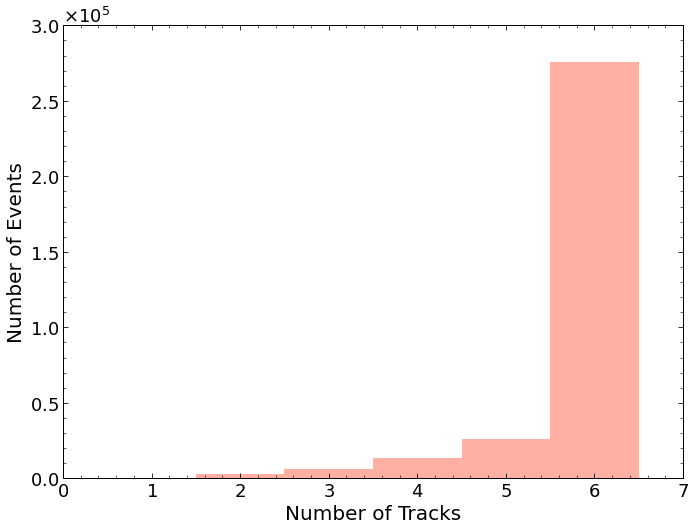

In [12]:
def num_of_track(data):
  # return the number of non-zero tracks
  is_non_zero = t_train[:,:,0] != 0.
  return np.sum(is_non_zero.astype(int),axis=1)
n_track = num_of_track(t_train)
plt.hist(n_track, bins=np.arange(0,7)+0.5, color='tomato',alpha=0.5)
plt.xlabel('Number of Tracks')
plt.ylabel('Number of Events')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0, 0.5, 'Log(Energy)')

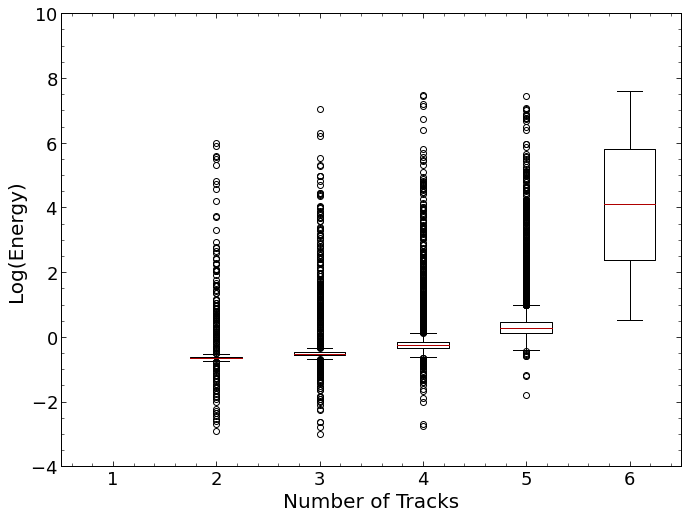

In [20]:
plt.boxplot((y_train[n_track==1],y_train[n_track==2],y_train[n_track==3],
             y_train[n_track==4],y_train[n_track==5],y_train[n_track==6]))
plt.xlabel('Number of Tracks')
plt.ylabel('Log(Energy)')

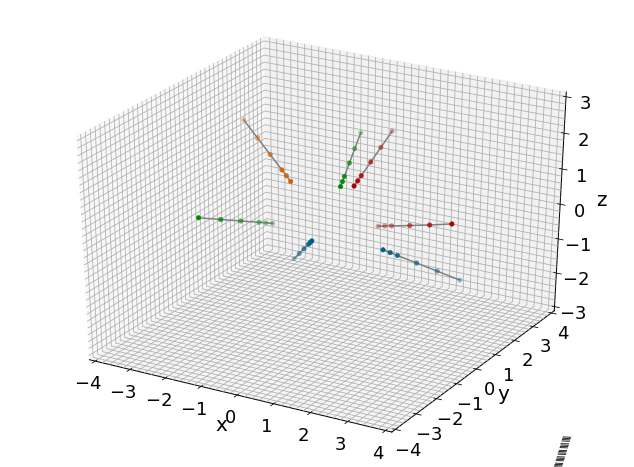

In [ ]:
def plot_track(data):
  # Plot the input tracks in x, y, z coordinate
  # return position in x, y, z coordinate
  theta = 2 * np.arctan(np.exp(-data[:,:,1]))
  phi = data[:,:,2]
  r = data[:,:,3]
  x = r * np.sin(theta) * np.cos(phi)
  y = r * np.sin(theta) * np.sin(phi)
  z = r * np.cos(theta)
  
  ax = plt.axes(projection='3d')
  ax.set_xlim(-4, 4); ax.set_ylim(-4, 4); ax.set_zlim(-3, 3);
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.set_title('pion tracks');
  for n in range(len(data)):
    if x[n,0] != 0:
      ax.plot3D(x[n,:], y[n,:], z[n,:], 'gray')
      ax.scatter3D(x[n,:], y[n,:], z[n,:])
  return x, y, z
plot_track(t_train[2:9,:,:])

(array([7.9119e+04, 5.8510e+04, 5.9936e+04, 5.9971e+04, 5.5133e+04,
        9.7250e+03, 9.4100e+02, 1.7000e+02, 4.8000e+01, 1.5000e+01]),
 array([-1.86091622, -0.38119265,  1.09853092,  2.5782545 ,  4.05797807,
         5.53770164,  7.01742521,  8.49714878,  9.97687236, 11.45659593,
        12.9363195 ]),
 <a list of 10 Patch objects>)

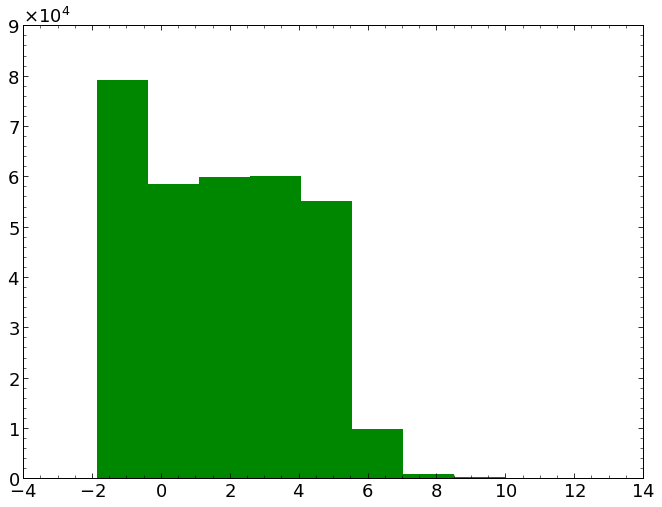

In [32]:
# Highest Pt track
plt.hist(t_train[:,0,0])

###PFN Model###

In [10]:
PFN = PFN(input_dim=4, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss, metrics=[])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 4)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    500         ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    10100       ['activation[0][0]']             
                                                                                              

In [ ]:
chkpoint = tf.keras.callbacks.ModelCheckpoint(ext_modelpath + 'PFN_regressor_weight_track_only.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
PFN_MDN_log = tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/ml4pion/model/PFN_track_log.log', separator=",", append=False)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=50, verbose=0, restore_best_weights=True)

PFN.fit(t_train, y_train,
        epochs=1000,
        batch_size=600,
        validation_data=(t_val, y_val),
        verbose=1,
        callbacks=[chkpoint, PFN_MDN_log])

Epoch 1/1000
539/540 [============================>.] - ETA: 0s - loss: 0.7078
Epoch 1: val_loss improved from inf to 0.08783, saving model to /content/drive/MyDrive/ml4pion/model/PFN_regressor_weight_track_only.h5
540/540 [==============================] - 3s 5ms/step - loss: 0.7075 - val_loss: 0.0878
Epoch 2/1000
537/540 [============================>.] - ETA: 0s - loss: 0.0810
Epoch 2: val_loss improved from 0.08783 to 0.08030, saving model to /content/drive/MyDrive/ml4pion/model/PFN_regressor_weight_track_only.h5
540/540 [==============================] - 2s 3ms/step - loss: 0.0809 - val_loss: 0.0803
Epoch 3/1000
536/540 [============================>.] - ETA: 0s - loss: 0.0791
Epoch 3: val_loss did not improve from 0.08030
540/540 [==============================] - 2s 4ms/step - loss: 0.0791 - val_loss: 0.0845
Epoch 4/1000
534/540 [============================>.] - ETA: 0s - loss: 0.0793
Epoch 4: val_loss did not improve from 0.08030
540/540 [==============================] - 2s 3

In [9]:
# load model
PFN.load_weights('/content/drive/MyDrive/ml4pion/model/PFN_regressor_weight_track_only.h5')

In [ ]:
# load loss training log
pfn_track_history = open('/content/drive/MyDrive/ml4pion/model/PFN_track_log.log','r')
lines = pfn_track_history.read().splitlines()
loss_history = np.zeros((len(lines), 3))
for i in range(1,len(lines)):
  loss_history[i,:] = lines[i].split(",")
loss_history = loss_history.astype(float)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


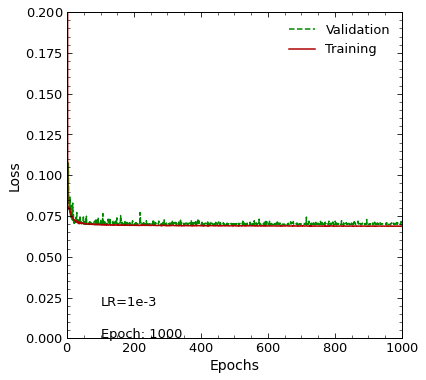

In [ ]:
fig = plt.figure(figsize=(6,6))
plt.plot(loss_history[:,2], label="Validation",linestyle='dashed')
plt.plot(loss_history[:,1], label="Training")
plt.ylim(0,0.2)
plt.yticks(fontsize=13)
plt.xlim(0,1000)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
plt.text(100, 0.02, 'LR=1e-3', fontsize=13)
plt.text(100, 0, 'Epoch: 1000', fontsize=13)

plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 799.992x599.976 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


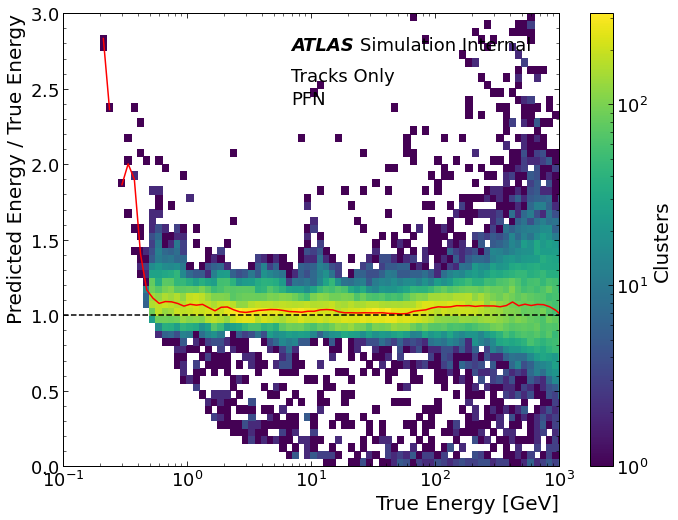

In [10]:
PFN_predict = PFN.predict(t_test)
xcenter, med_PFN_5f, std = rum.responsePlot(np.exp(y_test), np.exp(PFN_predict[:,0])/np.exp(y_test),
                                          atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                                          xlim = (0.1, 1000),
                                          textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Tracks Only'},
                                                      {'x': 0.46, 'y': 0.8,  'text': 'PFN'}])

###MDN Model###

In [8]:
# make model
def point_mask_fn(X, mask_val=0.):
    return Kb.cast(Kb.any(Kb.not_equal(X, mask_val), axis=-1), Kb.dtype(X))

def convert_to_tensor(X):
    return tf.concat([tfp.distributions.Distribution.mean(X), tfp.distributions.Distribution.stddev(X)],1)

def ParticleFlow_MDN(num_features,num_components):
    
    name = "PFN_MDN_" + str(num_components) + "_components"
    event_shape = [1]

    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)


    inputs = keras.Input(shape=(None, num_features), name='input')

    dense_0 = layers.Dense(100)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(inputs)
    activation_0 = layers.Activation('relu', name="activation_0")(t_dist_0)
    
    dense_1 = layers.Dense(100)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(activation_0)
    activation_1 = layers.Activation('relu', name='activation_1')(t_dist_1)
    
    dense_2 = layers.Dense(128)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(activation_1)
    activation_2 = layers.Activation('relu', name='activation_2')(t_dist_2)
    
    lambda_layer = layers.Lambda(point_mask_fn, output_shape=(None, None),
                                mask=None,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(1,1), name='sum')([lambda_layer, activation_2])
    
    dense_3 = layers.Dense(100, name='dense_0')(sum_layer)
    activation_3 = layers.Activation('relu', name="activation_3")(dense_3)
    
    dense_4 = layers.Dense(100, name='dense_1')(activation_3)
    activation_4 = layers.Activation('relu', name="activation_4")(dense_4)
    
    dense_5 = layers.Dense(100, name='dense_2')(activation_4)
    activation_5 = layers.Activation('relu', name="activation_5")(dense_5)
    
    dense_6 = layers.Dense(units=params_size, activation=lambda x: tf.clip_by_value(x, -30., 30.))(activation_5)

    
    mdn_0 = tfp.layers.MixtureNormal(num_components, event_shape, validate_args=True,
                                          convert_to_tensor_fn=convert_to_tensor)(dense_6)
    
    return keras.Model(inputs=inputs, outputs=mdn_0, name=name)


In [9]:
netOpt = tf.keras.optimizers.Adam(
    learning_rate=.002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)


def PFN_MDN_compile(comp=3):
  PFN_MDN = ParticleFlow_MDN(num_features=4, num_components=comp)
  PFN_MDN.compile(optimizer = netOpt, loss=lambda y, p_y: -p_y.log_prob(y))
  PFN_MDN.summary()
  return PFN_MDN

PFN_MDN1 = PFN_MDN_compile(comp=1)
PFN_MDN3 = PFN_MDN_compile(comp=3)
PFN_MDN10 = PFN_MDN_compile(comp=10)

Model: "PFN_MDN_1_components"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 4)]    0           []                               
                                                                                                  
 t_dist_0 (TimeDistributed)     (None, None, 100)    500         ['input[0][0]']                  
                                                                                                  
 activation_0 (Activation)      (None, None, 100)    0           ['t_dist_0[0][0]']               
                                                                                                  
 t_dist_1 (TimeDistributed)     (None, None, 100)    10100       ['activation_0[0][0]']           
                                                                               

In [10]:
def train_PFN_MDN(PFN_MDN, comp=3, epochs=100, batch_size=600):
  chkpoint = tf.keras.callbacks.ModelCheckpoint(ext_modelpath + 'PFN_MDN_regressor_weight_track_only_'+str(comp)+'comp.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
  PFN_MDN_log = tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/ml4pion/model/PFN_MDN_track_log_'+str(comp)+'comp.log', separator=",", append=False)
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=50, verbose=0, restore_best_weights=True)

  PFN_MDN.fit(t_train, y_train,
          epochs=100,
          batch_size=600,
          validation_data=(t_val, y_val),
          verbose=1,
          callbacks=[chkpoint, PFN_MDN_log])
  return PFN_MDN

In [ ]:
PFN_MDN10 = train_PFN_MDN(PFN_MDN10, comp=10)

Epoch 1/100
532/540 [============================>.] - ETA: 0s - loss: 0.2865
Epoch 1: val_loss improved from inf to -0.28353, saving model to /content/drive/MyDrive/ml4pion/model/PFN_MDN_regressor_weight_track_only_10comp.h5
540/540 [==============================] - 5s 5ms/step - loss: 0.2794 - val_loss: -0.2835
Epoch 2/100
536/540 [============================>.] - ETA: 0s - loss: -0.2637
Epoch 2: val_loss improved from -0.28353 to -0.44478, saving model to /content/drive/MyDrive/ml4pion/model/PFN_MDN_regressor_weight_track_only_10comp.h5
540/540 [==============================] - 2s 4ms/step - loss: -0.2637 - val_loss: -0.4448
Epoch 3/100
539/540 [============================>.] - ETA: 0s - loss: -0.2734
Epoch 3: val_loss did not improve from -0.44478
540/540 [==============================] - 2s 4ms/step - loss: -0.2731 - val_loss: -0.2214
Epoch 4/100
537/540 [============================>.] - ETA: 0s - loss: -0.8195
Epoch 4: val_loss improved from -0.44478 to -1.39558, saving mod

In [11]:
PFN_MDN1.load_weights('/content/drive/MyDrive/ml4pion/model/PFN_MDN_regressor_weight_track_only_1comp.h5')
PFN_MDN3.load_weights('/content/drive/MyDrive/ml4pion/model/PFN_MDN_regressor_weight_track_only_3comp.h5')
PFN_MDN10.load_weights('/content/drive/MyDrive/ml4pion/model/PFN_MDN_regressor_weight_track_only_10comp.h5')

In [ ]:
# load loss training log
PFN_MDN_track_history = open('/content/drive/MyDrive/ml4pion/model/PFN_MDN_track_log.log','r')
lines = PFN_MDN_track_history.read().splitlines()
loss_history = np.zeros((len(lines), 3))
for i in range(1,len(lines)):
  loss_history[i,:] = lines[i].split(",")
loss_history = loss_history.astype(float)

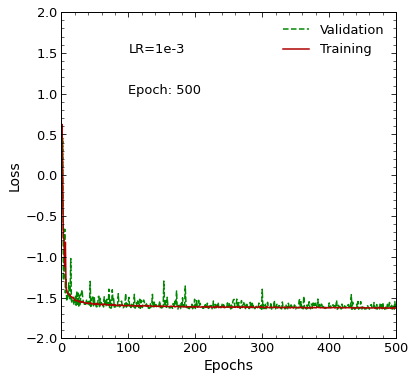

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,6))
plt.plot(loss_history[:,2], label="Validation",linestyle='dashed')
plt.plot(loss_history[:,1], label="Training")
plt.ylim(-2,2)
plt.yticks(fontsize=13)
plt.xlim(0,500)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
plt.text(100, 1.5, 'LR=1e-3', fontsize=13)
plt.text(100, 1, 'Epoch: 500', fontsize=13)

plt.show()

###Model Eval###

In [15]:
def eval_with_plots(PFN_MDN_tuples, t_test, y_test):
  for PFN_MDN in PFN_MDN_tuples:

    PFN_MDN_predict = PFN_MDN.predict(t_test)
    PFN_MDN_predict = PFN_MDN_predict.flatten()

    # Plot 1: Response Plot
    xcenter, medPFNMDN, std = rum.responsePlot(np.exp(y_test),
                                          np.exp(PFN_MDN_predict[:,0])/np.exp(y_test),
                                          atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                                          xlim = (0.1, 1000),
                                          textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Tracks Only'},
                                                                  {'x': 0.46, 'y': 0.8,  'text': PFN_MDN.name}])
    
    # Plot 2: Resolution Plot
    xcenter, PFN_5f = resolutionPlot(np.exp(y_test), np.exp(PFN_MDN_predict)/np.exp(y_test),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True, x_step=0.1,
                        xlim=(0.1,1000),
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Clusters Only'},
                                    {'x': 0.56, 'y': 0.8,  'text': PFN_MDN.name}])
    
    # Plot 3: Predicted IQR
    weight, pred_mean, pred_std = get_parameters(PFN_MDN)
    pred_iqr = pred_std * np.exp(pred_mean)
    iqr_over_median = 2 * pred_iqr / np.exp(pred_mean)
    xcenter, iqrOverMed_MDN, learned_error = ru.responsePlot(np.exp(Y), iqr_over_median/2,
                    'median',
                    atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                    xlim=(0.1,1000), ylim=(0,3), baseline=False, fill_error=True,
                    step=0.1,
                    xlabel='True Energy [GeV]', ylabel='Predicted IQR / (2 x Predicted Energy)',
                    textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Clusters Only'},
                                {'x': 0.38, 'y': 0.8,  'text': 'PFN+MDN'}])


    pred_mean, pred_std = eval_cal(t_test, 500, PFN_MDN)
    xcenter, iqrPFNMDN = resolutionPlot(x=np.exp(y_test), y=np.exp(pred_mean)/np.exp(y_test),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        x_step=0.05,
                        xlim = (0.1, 1000),
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Clusters Only'},
                                    {'x': 0.56, 'y': 0.8,  'text': PFN_MDN.name}])
    
    
    pu.lineOverlay(xcenter=xcenter, lines = [iqrPFNMDN, iqrPFNMDN3],
                labels = ['PFN + MDN 1 mode', 'PFN + MDN 3 modes'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegLCEMB1TileBar0E1T0All.pdf",
                x_min = 0.1, y_max = .75,
                atlas_x = 0.56, atlas_y = 0.75, simulation = True,
                textlist = [{'x': 0.56, 'y': 0.65, 'text': 'Track Only'}])
    
    # response median plot
    pu.lineOverlay(xcenter=xcenter, lines = [medPFNMDN, medPFNMDN3],
                labels = ['PFN + MDN 1 mode', 'PFN + MDN 3 modes'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response Median',
                x_min = 0.1,y_min=0.0,y_max = 3,
                extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.56, atlas_y = 0.75, simulation = True,
                textlist = [{'x': 0.56, 'y': 0.65, 'text': 'Tracks Only'}])

<Figure size 799.992x599.976 with 0 Axes>

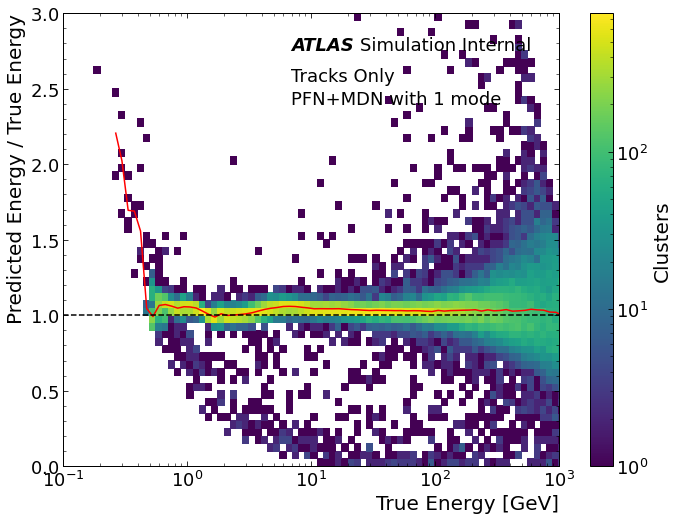

<Figure size 799.992x599.976 with 0 Axes>

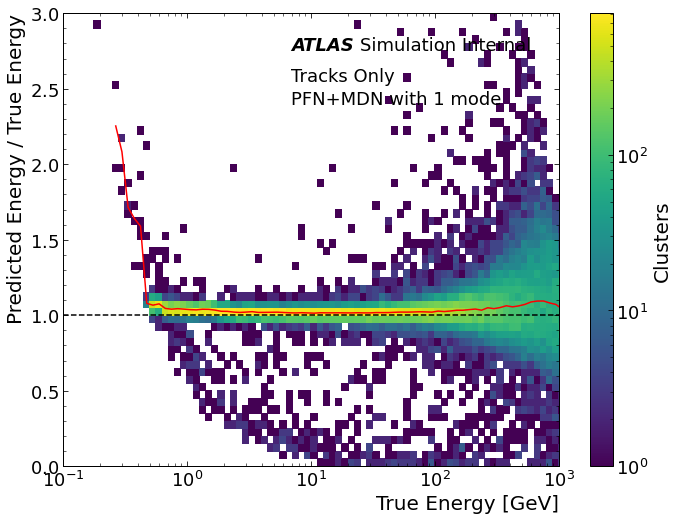

In [16]:
PFN_MDN_predict = PFN_MDN1.predict(t_test)
xcenter, medPFNMDN, std = rum.responsePlot(np.exp(y_test),
                                          np.exp(PFN_MDN_predict[:,0])/np.exp(y_test),
                                          atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                                          xlim = (0.1, 1000),
                                          textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Tracks Only'},
                                                                  {'x': 0.46, 'y': 0.8,  'text': 'PFN+MDN with 1 mode'}])
PFN_MDN_predict10 = PFN_MDN10.predict(t_test)
xcenter, medPFNMDN, std = rum.responsePlot(np.exp(y_test),
                                          np.exp(PFN_MDN_predict10[:,0])/np.exp(y_test),
                                          atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                                          xlim = (0.1, 1000),
                                          textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Tracks Only'},
                                                                  {'x': 0.46, 'y': 0.8,  'text': 'PFN+MDN with 1 mode'}])

<Figure size 799.992x599.976 with 0 Axes>

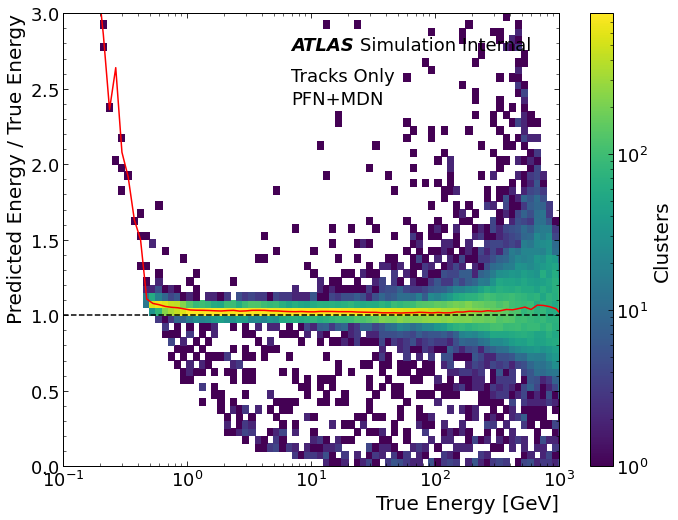

In [ ]:
weight = PFN_MDN3(t_test).submodules[1].probs_parameter().numpy()
mu = PFN_MDN3(t_test).submodules[3].mean().numpy()
mu = mu.reshape(mu.shape[0],mu.shape[1])
mean3 = tol_mean(weight, mu)

xcenter3, medPFNMDN3, std3 = rum.responsePlot(np.exp(y_test),
                          np.exp(mean3)/np.exp(y_test),
                          atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                          xlim = (0.1, 1000),
                          textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Tracks Only'},
                                                  {'x': 0.46, 'y': 0.8,  'text': 'PFN+MDN'}])

<Figure size 799.992x599.976 with 0 Axes>

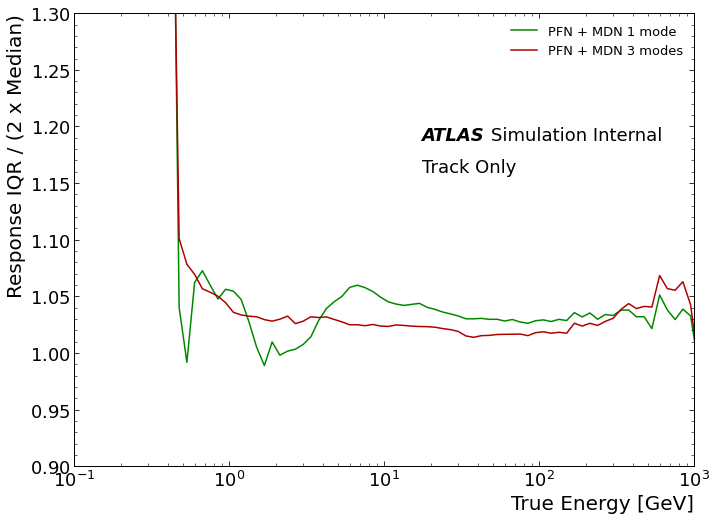

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = [medPFNMDN, medPFNMDN3],
                labels = ['PFN + MDN 1 mode', 'PFN + MDN 3 modes'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegLCEMB1TileBar0E1T0All.pdf",
                x_min = 0.1, y_max = 1.3, y_min=0.9,
                atlas_x = 0.56, atlas_y = 0.75, simulation = True,
                textlist = [{'x': 0.56, 'y': 0.65, 'text': 'Track Only'}])

<Figure size 799.992x599.976 with 0 Axes>

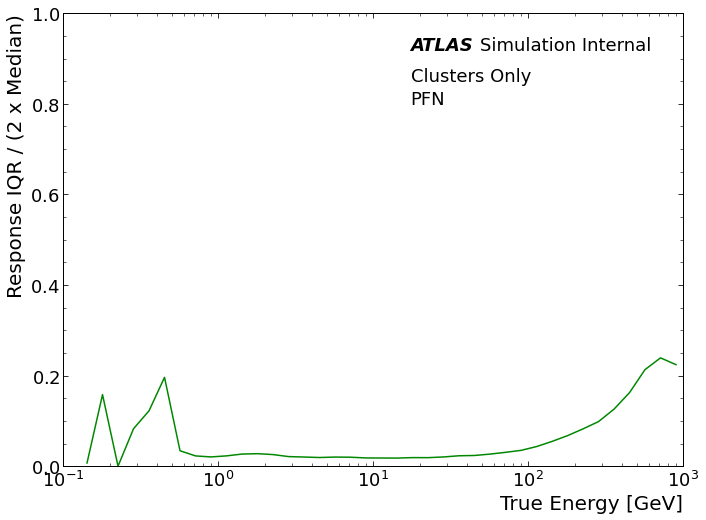

In [ ]:
PFN_predict = PFN_predict.flatten()
xcenter, PFN_5f = resolutionPlot(np.exp(y_test), np.exp(PFN_predict)/np.exp(y_test),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True, x_step=0.1,
                        xlim=(0.1,1000),
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Clusters Only'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN'}])


<Figure size 799.992x599.976 with 0 Axes>

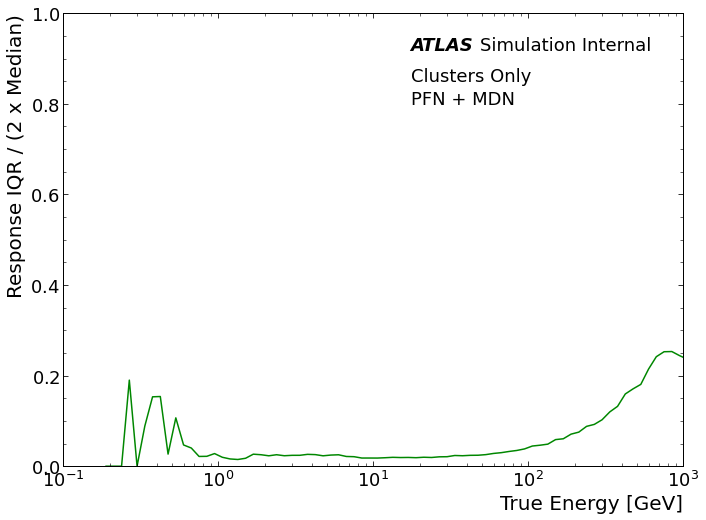

In [ ]:
pred_mean, pred_std = eval_cal(t_test, 500, PFN_MDN1)
xcenter, iqrPFNMDN = resolutionPlot(x=np.exp(y_test), y=np.exp(pred_mean)/np.exp(y_test),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        x_step=0.05,
                        xlim = (0.1, 1000),
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Clusters Only'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN + MDN'}])

<Figure size 799.992x599.976 with 0 Axes>

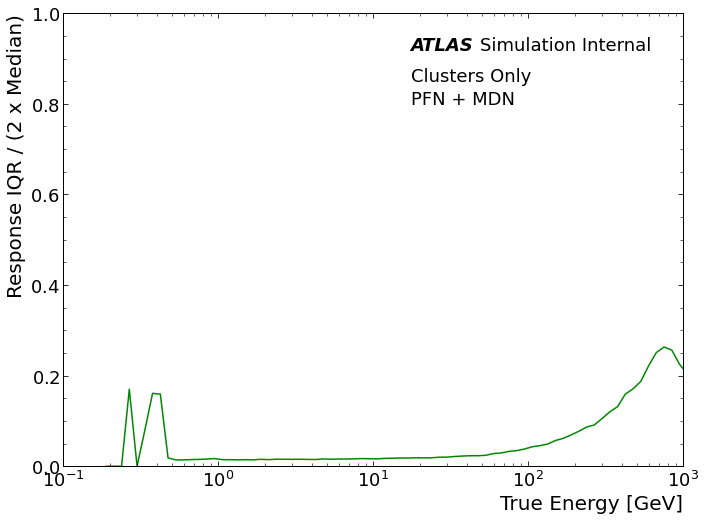

In [ ]:
pred_mean3, pred_std3 = eval_cal(t_test, 500, PFN_MDN3)
xcenter3, iqrPFNMDN3 = resolutionPlot(x=np.exp(y_test), y=np.exp(pred_mean3)/np.exp(y_test),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        x_step=0.05,
                        xlim = (0.1, 1000),
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Clusters Only'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN + MDN'}])

<Figure size 799.992x599.976 with 0 Axes>

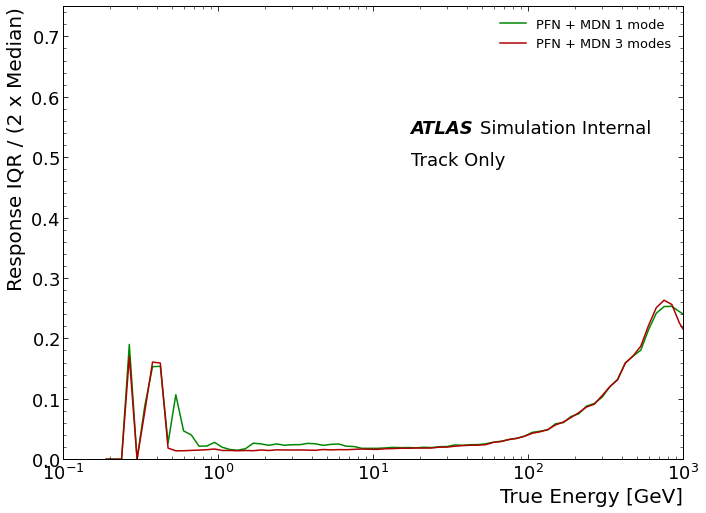

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = [iqrPFNMDN, iqrPFNMDN3],
                labels = ['PFN + MDN 1 mode', 'PFN + MDN 3 modes'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegLCEMB1TileBar0E1T0All.pdf",
                x_min = 0.1, y_max = .75,
                atlas_x = 0.56, atlas_y = 0.75, simulation = True,
                textlist = [{'x': 0.56, 'y': 0.65, 'text': 'Track Only'}])

<Figure size 799.992x599.976 with 0 Axes>

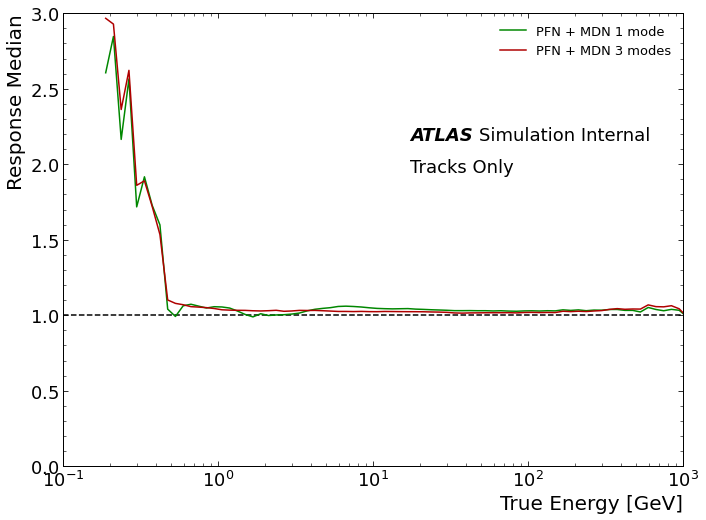

In [ ]:
# response median plot
pu.lineOverlay(xcenter=xcenter, lines = [medPFNMDN, medPFNMDN3],
                labels = ['PFN + MDN 1 mode', 'PFN + MDN 3 modes'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response Median',
                x_min = 0.1,y_min=0.0,y_max = 3,
                extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.56, atlas_y = 0.75, simulation = True,
                textlist = [{'x': 0.56, 'y': 0.65, 'text': 'Tracks Only'}])

<Figure size 799.992x599.976 with 0 Axes>

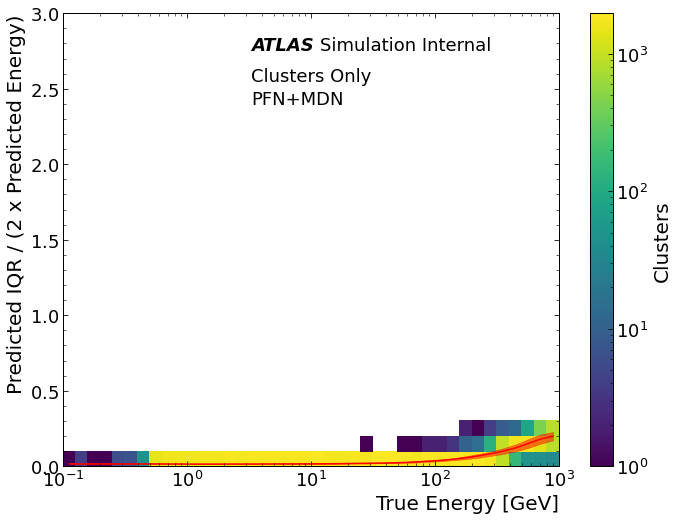

In [ ]:
pred_iqr = pred_std * np.exp(pred_mean)
iqr_over_median = 2 * pred_iqr / np.exp(pred_mean)
xcenter, iqrOverMed_MDN, learned_error = rum.responsePlot(np.exp(y_test), iqr_over_median/2,
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlim=(0.1,1000), ylim=(0,3), baseline=False, fill_error=True,
                 step=0.1,
                 xlabel='True Energy [GeV]', ylabel='Predicted IQR / (2 x Predicted Energy)',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Clusters Only'},
                             {'x': 0.38, 'y': 0.8,  'text': 'PFN+MDN'}])

(0.0, 0.7)

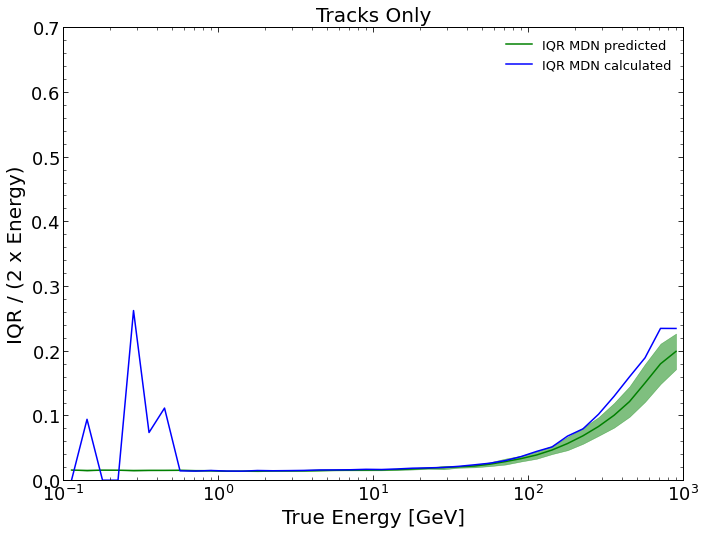

In [ ]:
upper = iqrOverMed_MDN-learned_error
lower = iqrOverMed_MDN+learned_error
plt.plot(xcenter, iqrOverMed_MDN, label='IQR MDN predicted', color='green')
plt.fill_between(xcenter, lower, upper, alpha=0.5, color='green')
plt.plot(xcenter, iqrPFNMDN, 'b', label='IQR MDN calculated')
plt.title('Tracks Only')
plt.xlabel('True Energy [GeV]')
plt.ylabel('IQR / (2 x Energy)')
plt.legend()
plt.xscale('log')
plt.xlim(0.1,1000)
plt.ylim(0,0.7)

<Figure size 799.992x599.976 with 0 Axes>

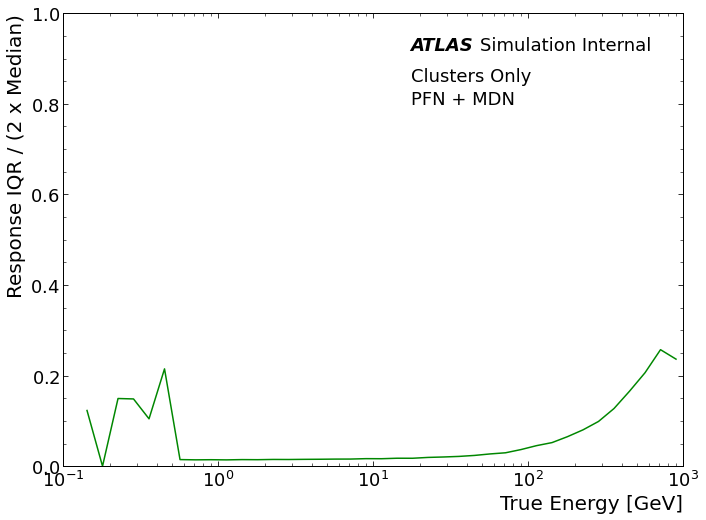

In [ ]:
# Calculated results
xcenter, iqrPFNMDN = resolutionPlot(x=np.exp(y_test), y=np.exp(Pm_mdn_predict[:,0])/np.exp(y_pt_test),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        x_step=0.1,
                        xlim = (0.1, 1000),
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Clusters Only'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN + MDN'}])

(0.0, 0.7)

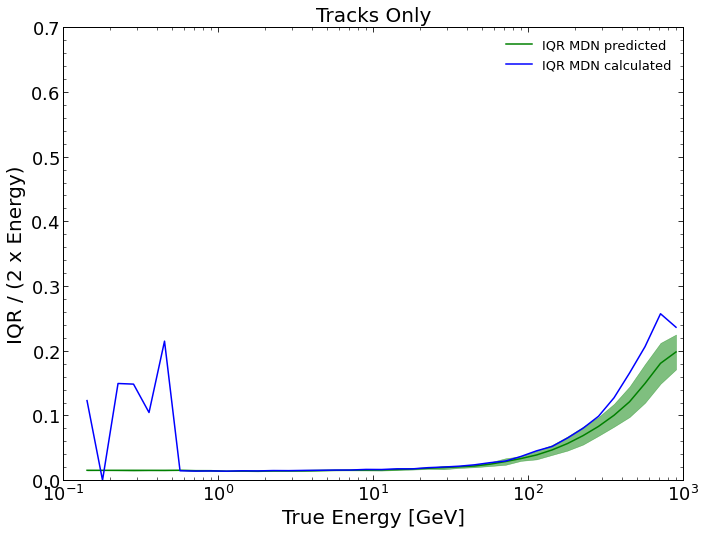

In [ ]:
upper = iqrOverMed_MDN-learned_error
lower = iqrOverMed_MDN+learned_error
plt.plot(xcenter, iqrOverMed_MDN, label='IQR MDN predicted', color='green')

plt.fill_between(xcenter, lower, upper, alpha=0.5, color='green')
plt.plot(xcenter, iqrPFNMDN, 'b', label='IQR MDN calculated')
#plt.plot(xcenter, PFN_5f, 'r',label='PFN')
#plt.plot(xcenter, PFN_5f, 'b-', label='IQR PFN')
plt.title('Tracks Only')
plt.xlabel('True Energy [GeV]')
plt.ylabel('IQR / (2 x Energy)')
plt.legend()
plt.xscale('log')
plt.xlim(0.1,1000)
plt.ylim(0,0.7)

<Figure size 799.992x599.976 with 0 Axes>

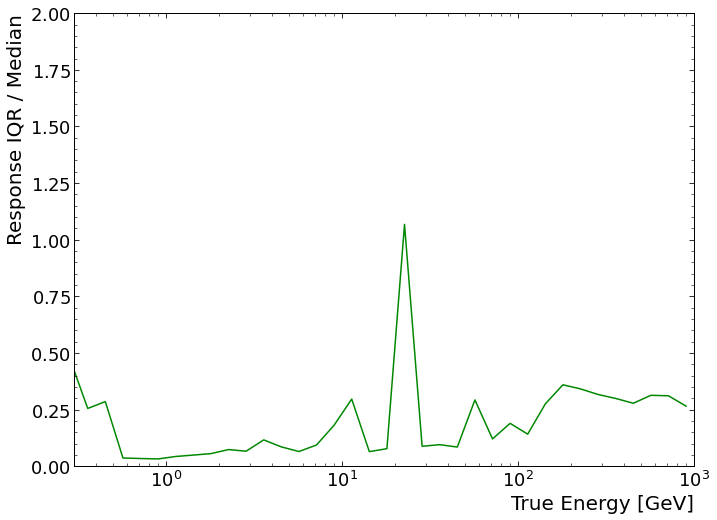

<Figure size 799.992x599.976 with 0 Axes>

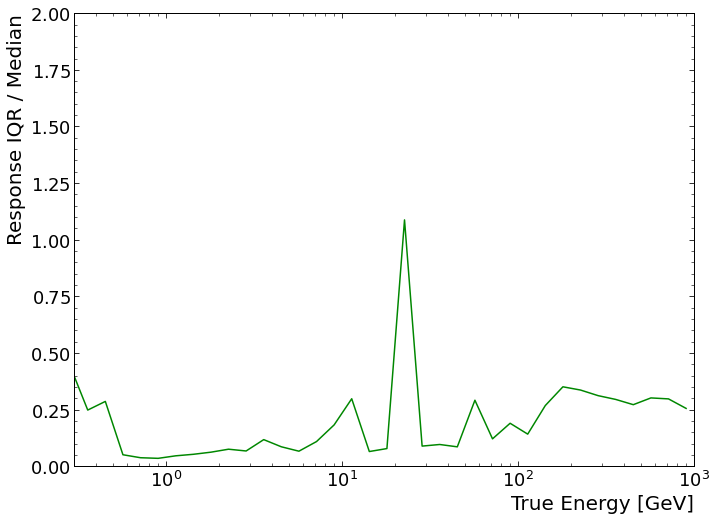

<Figure size 799.992x599.976 with 0 Axes>

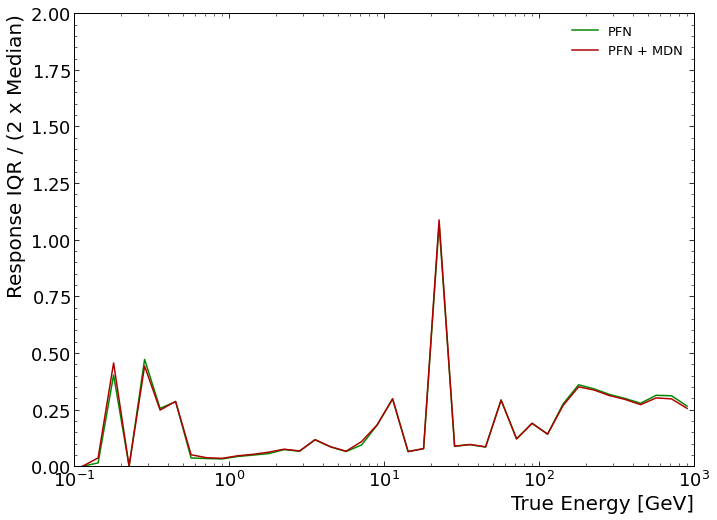

In [ ]:
xcenter, resolution1 = rum.resolutionPlot(np.exp(y_test), np.exp(Pm_mdn_predict[:,0])/np.exp(y_test))
xcenter, resolution2 = rum.resolutionPlot(np.exp(y_test), np.exp(Pm_predict[:,0])/np.exp(y_test))
pu.lineOverlay(xcenter=xcenter, lines = [resolution1, resolution2],
               labels = ['PFN', 'PFN + MDN'],
               xlabel = 'True Energy [GeV]', ylabel = 'Response IQR / (2 x Median)')

(0.3, 1500)

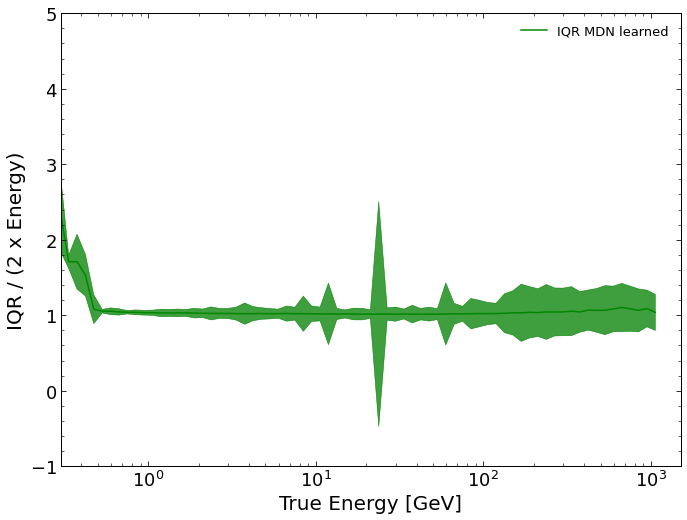

In [ ]:
lower = profileXMed - profileXstd
upper = profileXMed + profileXstd
plt.fill_between(xcenter, lower, upper, alpha=0.5, color='green')

plt.plot(xcenter, profileXMed, label='IQR MDN learned')
#plt.errorbar(xcenter, iqrOverMed_MDN_learned, yerr=learned_error, label='IQR MDN learned')
plt.fill_between(xcenter, lower, upper, alpha=0.5, color='green')
#plt.plot(xcenter, iqrPFNMDN, 'r-', label='IQR MDN calculated')
#plt.plot(xcenter, PFN_5f, 'b-', label='IQR PFN')
plt.xlabel('True Energy [GeV]')
plt.ylabel('IQR / (2 x Energy)')
plt.legend()
plt.xscale('log')
plt.xlim(0.3,1500)

In [ ]:
plt.plot(xcenter, iqrOverMed_MDN_learned, label='IQR MDN learned')

###Distribution Analysis###

#### usage of the sigma distribution ####
- make a 2D plot of the predicted error vs true energy
- find a good separation rule and make two populations of events: good and bad resolution. Then make the response and IQR plots  for these 2 population separately and compare to the default PFN

In [19]:
#https://stats.stackexchange.com/questions/241187/calculating-standard-deviation-after-log-transformation
def mu_exp(mu, sigma):
  # transform params back to exp scale
  return np.exp(mu + sigma**2 / 2)

def sigma_exp(mu, sigma):
  return np.sqrt( mu_exp(mu,sigma)**2 * (np.exp(sigma**2 - 1)) )

def get_parameters_mix_exp(weight, mu, sigma):
  # Cumpute params of mixture distribution, then transform to exp
  mean = tol_mean(weight, mu)
  std = tol_std(weight, mu, sigma)
  return mu_exp(mean, std), sigma_exp(mean, std)

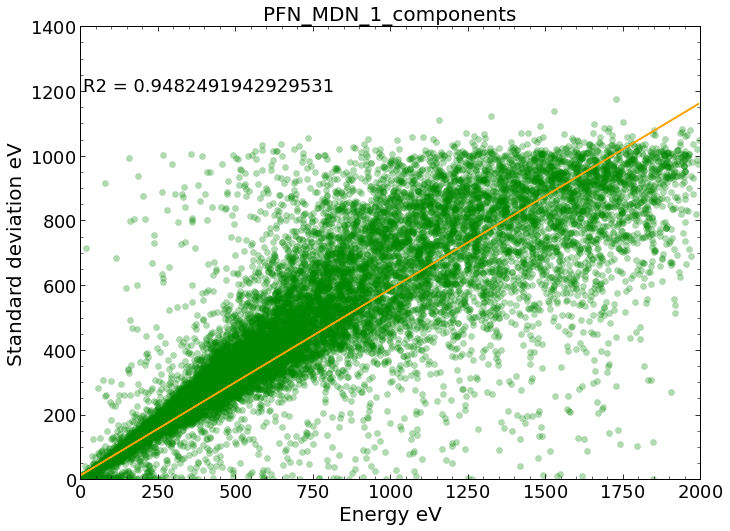

In [31]:
def energy_std_plot(PFN_MDN, y_test):
  # make a 2D plot of the predicted error vs true energy
  y_test_exp = np.exp(y_test)
  weight, mean, std = get_parameters(PFN_MDN, t_test)
  mean_, std_ = get_parameters_mix_exp(weight, mean, std)

  m, b = np.polyfit(y_test_exp, std_, 1)
  r2 = np.corrcoef(np.array([y_test_exp, std_]))[0,1]

  plt.scatter(y_test_exp, std_, alpha=0.3)
  plt.plot(y_test_exp, m*y_test_exp + b, 'orange')
  plt.text(10, 1200, 'R2 = ' + str(r2), wrap=True)
  plt.xlabel('Energy eV')
  plt.ylabel('Standard deviation eV')
  plt.title(PFN_MDN.name)
  plt.xlim((0, 2000))
  plt.ylim((0, 1400))

energy_std_plot(PFN_MDN1, y_test)

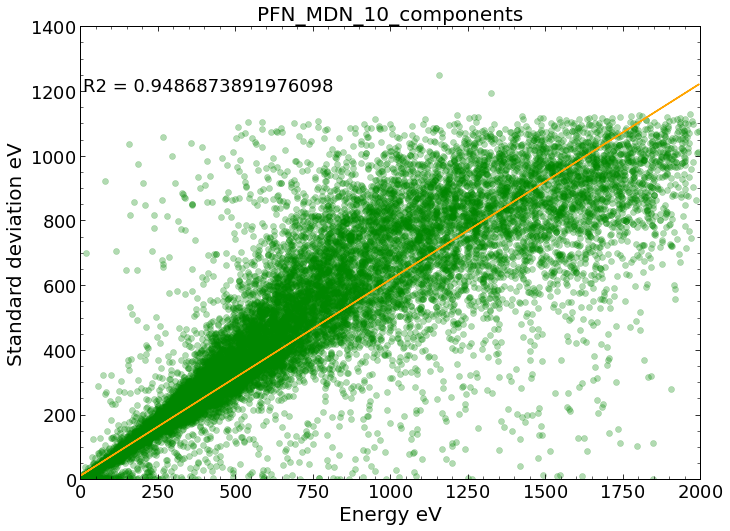

In [34]:
energy_std_plot(PFN_MDN10, y_test)

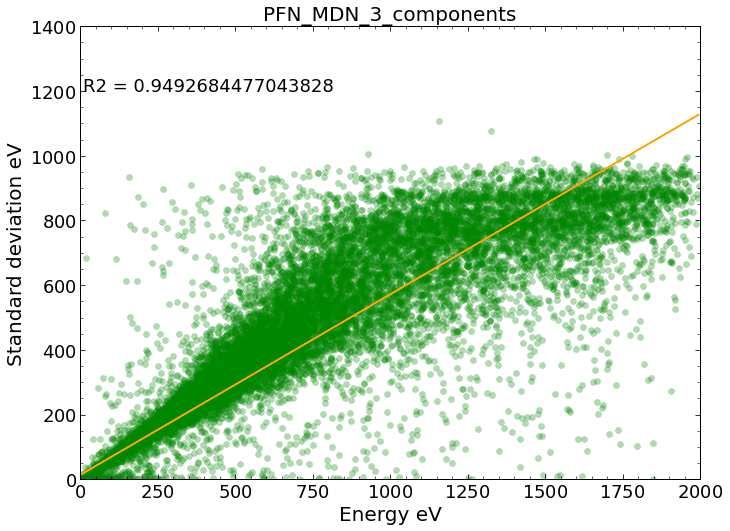

In [33]:
energy_std_plot(PFN_MDN3, y_test)

#### modes number comparison ####
- study the true pt spectrum for cases where more than 1 mode matters
- make three response plot using each mode to try to understand if there is a kinematic regime where a mode dominates

In [35]:
def find_multi_domin(weight, mu, sigma, weight_tol=0.1, diff_tol=0.5):
  # Take tranined parameters
  # Return distributions that must satisfy:
  #   1. largest weight is much larger than second largest
  #   2. the difference of their means is significant
  max_index = np.argsort(weight)[:,-1]
  second_index = np.argsort(weight)[:,-2]

  max_weight = np.take_along_axis(weight, max_index[:,None], axis=1)
  second_weight = np.take_along_axis(weight, second_index[:,None], axis=1)
  max_mu = np.take_along_axis(mu, max_index[:,None], axis=1)
  second_mu = np.take_along_axis(mu, second_index[:,None], axis=1)
  max_sigma = np.take_along_axis(sigma, max_index[:,None], axis=1)

  weight_mask = (second_weight / max_weight) > weight_tol
  diff_mask = np.abs(second_mu - max_mu) > max_sigma*diff_tol
  index_prime = (weight_mask * diff_mask).flatten()
  print(str(np.sum(1*index_prime)) + ' out of ' + str(len(weight)) + ' found')
  return index_prime

weight, mu, sigma = get_parameters(PFN_MDN3, t_test)
index_prime = find_multi_domin(weight, mu, sigma)

def seperate_data(mask, t, y):
  return t[mask], y[mask], t[np.invert(mask)], y[np.invert(mask)]

t_test_prime = t_test[index_prime]
y_test_prime = y_test[index_prime]
t_test_invert = t_test[np.invert(index_prime)]
y_test_invert = y_test[np.invert(index_prime)]

9101 out of 64714 found


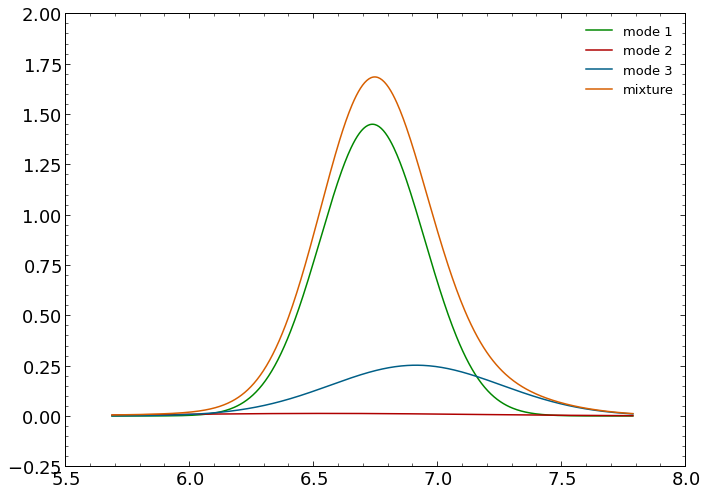

In [38]:
def get_parameters(PFN_MDN, t_test):
  weight = PFN_MDN(t_test).submodules[1].probs_parameter().numpy()
  mu = PFN_MDN(t_test).submodules[3].mean().numpy()
  sigma = PFN_MDN(t_test).submodules[3].stddev().numpy()
  mu = mu.reshape(mu.shape[0],mu.shape[1])
  sigma = sigma.reshape(sigma.shape[0],sigma.shape[1])
  return weight, mu, sigma

def plot_distribution(weight, mu, sigma, resolution=500):
  # Input data size should not be too large
  # Plot the gaussian distributions given by the parameters

  # Set x limit based on largest mode
  max_i = np.argmax(weight)
  x_min, x_max = mu[max_i] - 5*sigma[max_i], mu[max_i] + 5*sigma[max_i]
  x = np.linspace(x_min,x_max,resolution)
  g = lambda x, w, mu, sigma: w * np.exp(-(((x-mu)/sigma)**2)/2) / (sigma*np.sqrt(2*np.pi))

  y = x*0
  for i in range(len(weight)):
    g_one = g(x, weight[i], mu[i], sigma[i])
    plt.plot(x, g_one, label='mode '+str(i+1))
    y += g_one
  plt.plot(x,y, label='mixture')
  plt.legend()


weight, mu, sigma = get_parameters(PFN_MDN3, t_test_prime)
plot_distribution(weight[21,:], mu[21,:], sigma[21,:])

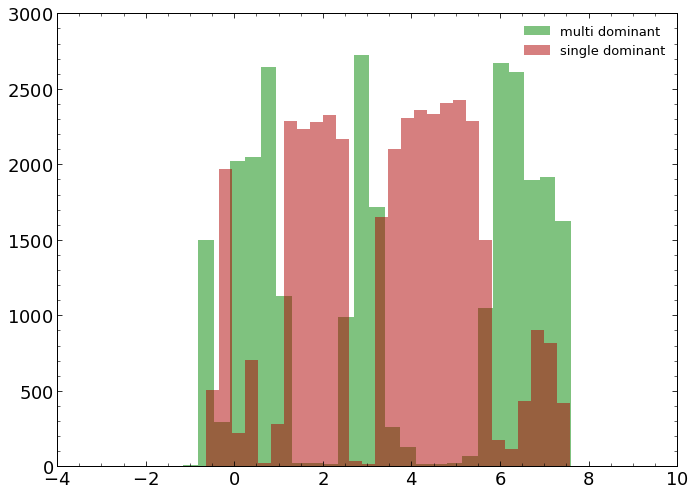

In [41]:
plt.hist(y_test_prime,alpha=0.5,label='multi dominant',bins=40)
plt.hist(y_test_invert,alpha=0.5,label='single dominant',bins=40)
plt.legend()

<Figure size 799.992x599.976 with 0 Axes>

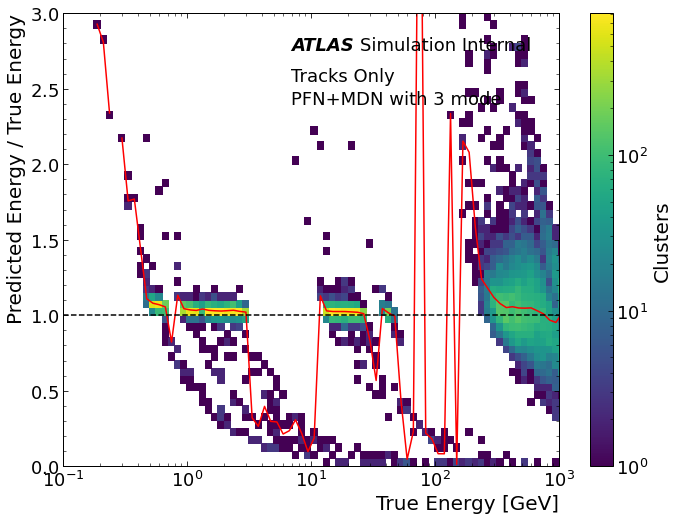

<Figure size 799.992x599.976 with 0 Axes>

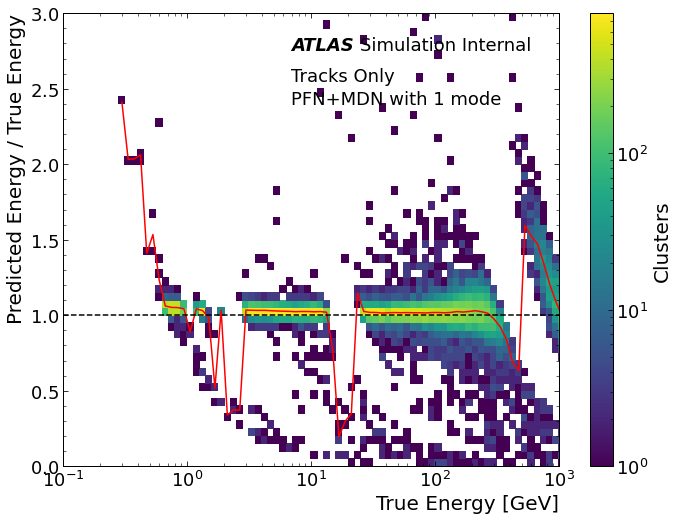

In [43]:
PFN_MDN_predict_prime = PFN_MDN3.predict(t_test_prime)
xcenter, medPFNMDN, std = rum.responsePlot(np.exp(y_test_prime),
                                          np.exp(PFN_MDN_predict_prime[:,0])/np.exp(y_test_prime),
                                          atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                                          xlim = (0.1, 1000),
                                          textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Tracks Only'},
                                                                  {'x': 0.46, 'y': 0.8,  'text': 'PFN+MDN with 3 mode'}])

PFN_MDN_predict_invert = PFN_MDN3.predict(t_test_invert)
xcenter, medPFNMDN, std = rum.responsePlot(np.exp(y_test_invert),
                                          np.exp(PFN_MDN_predict_invert[:,0])/np.exp(y_test_invert),
                                          atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                                          xlim = (0.1, 1000),
                                          textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Tracks Only'},
                                                                  {'x': 0.46, 'y': 0.8,  'text': 'PFN+MDN with 1 mode'}])

(array([1.1800e+02, 3.2700e+02, 8.3360e+03, 6.9790e+03, 5.3820e+03,
        5.1510e+03, 1.3373e+04, 7.9380e+03, 5.1280e+03, 4.3680e+03,
        1.9190e+03, 9.6200e+02, 3.2900e+02, 0.0000e+00, 0.0000e+00,
        4.5300e+02, 6.0200e+02, 5.9600e+02, 5.3400e+02, 7.5200e+02,
        4.7400e+02, 3.4800e+02, 2.3500e+02, 2.3100e+02, 6.0000e+01,
        6.2000e+01, 2.2000e+01, 1.4000e+01, 1.6000e+01, 5.0000e+00]),
 array([0.14649999, 0.16289486, 0.17928973, 0.1956846 , 0.21207947,
        0.22847433, 0.2448692 , 0.26126406, 0.27765894, 0.2940538 ,
        0.31044868, 0.32684353, 0.3432384 , 0.35963327, 0.37602815,
        0.392423  , 0.40881786, 0.42521274, 0.4416076 , 0.45800248,
        0.47439733, 0.4907922 , 0.50718707, 0.5235819 , 0.53997684,
        0.5563717 , 0.57276654, 0.5891614 , 0.6055563 , 0.62195116,
        0.638346  ], dtype=float32),
 <a list of 30 Patch objects>)

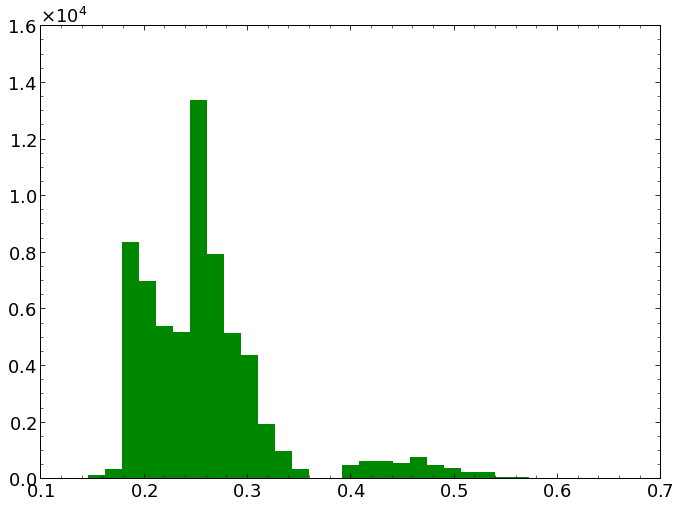

In [24]:
bad_std_mask = PFN_MDN_predict[:,1] > 0.38
plt.hist(PFN_MDN_predict[:,1],bins=30)

<Figure size 799.992x599.976 with 0 Axes>

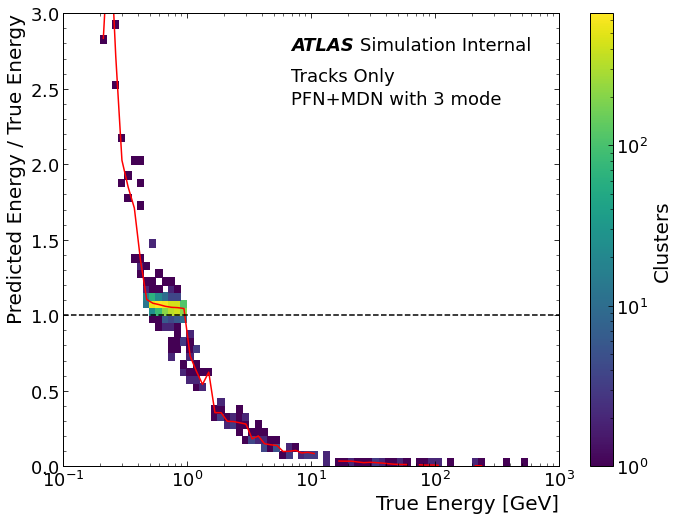

<Figure size 799.992x599.976 with 0 Axes>

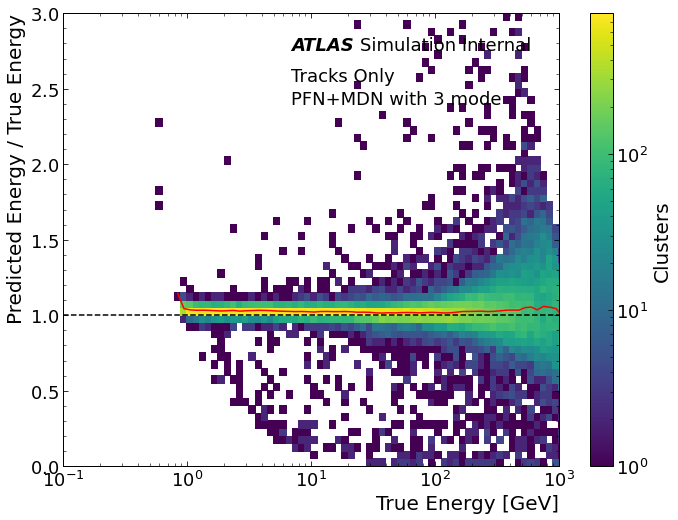

In [29]:
t_bad, y_bad, t_good, y_good = seperate_data(bad_std_mask, t_test, y_test)
predict_bad = PFN_MDN3.predict(t_bad)
xcenter, medPFNMDN, std = rum.responsePlot(np.exp(y_bad),
                                          np.exp(predict_bad[:,0])/np.exp(y_bad),
                                          atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                                          xlim = (0.1, 1000),
                                          textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Tracks Only'},
                                                                  {'x': 0.46, 'y': 0.8,  'text': 'PFN+MDN with 3 mode'}])
predict_good = PFN_MDN3.predict(t_good)
xcenter, medPFNMDN, std = rum.responsePlot(np.exp(y_good),
                                          np.exp(predict_good[:,0])/np.exp(y_good),
                                          atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                                          xlim = (0.1, 1000),
                                          textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Tracks Only'},
                                                                  {'x': 0.46, 'y': 0.8,  'text': 'PFN+MDN with 3 mode'}])

<Figure size 799.992x599.976 with 0 Axes>

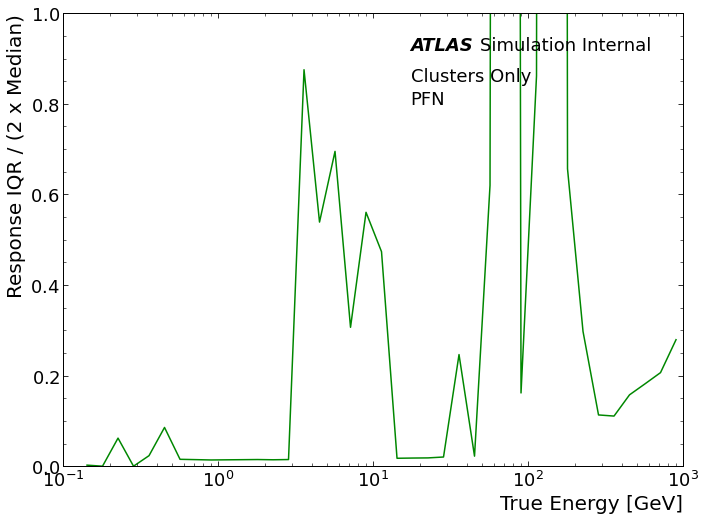

<Figure size 799.992x599.976 with 0 Axes>

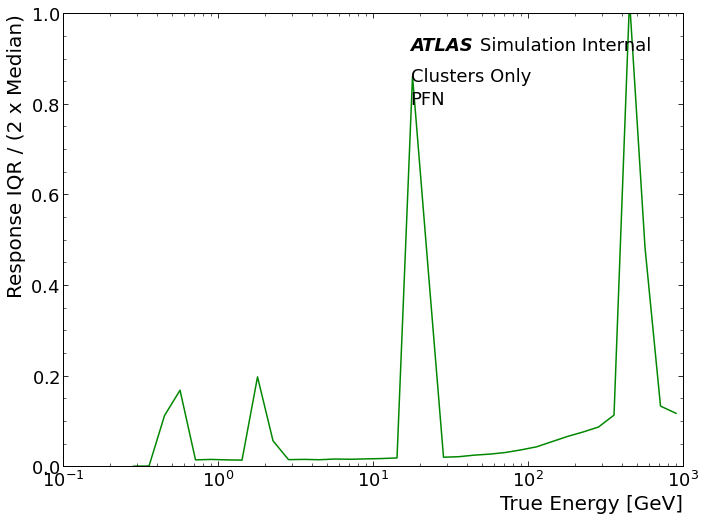

In [47]:
xcenter, PFN_MDN_prime = resolutionPlot(np.exp(y_test_prime), np.exp(PFN_MDN_predict_prime[:,0])/np.exp(y_test_prime),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True, x_step=0.1,
                        xlim=(0.1,1000),
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Clusters Only'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN'}])

xcenter, PFN_MDN_invert = resolutionPlot(np.exp(y_test_invert), np.exp(PFN_MDN_predict_invert[:,0])/np.exp(y_test_invert),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True, x_step=0.1,
                        xlim=(0.1,1000),
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Clusters Only'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN'}])

#####More Plot#####

In [ ]:
from util import resolution_util_modified as rum
_median = Pm_mdn_predict[:,0]
median = np.exp(_median)
sigma = Pm_mdn_predict[:,1]*median

# Calculate pull
pull = (median-np.exp(y_pt_test)) / sigma
badval_mask = np.logical_and(pull < 100, pull > -100)
pull = pull[badval_mask]

median_over_true = median / np.exp(y_test)   #   Reconstructed Energy / True Energy --- Resolution
iqr_over_median = 2 * sigma / median  # Reconstructed Energy Resolution Per Cluster --- Predicted Energy Resolution vs predicted energy -- predict resolution
iqr_over_true = 2 * sigma / np.exp(y_test)  # Pred Sigma / True Energy Per Cluster

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 799.992x599.976 with 0 Axes>

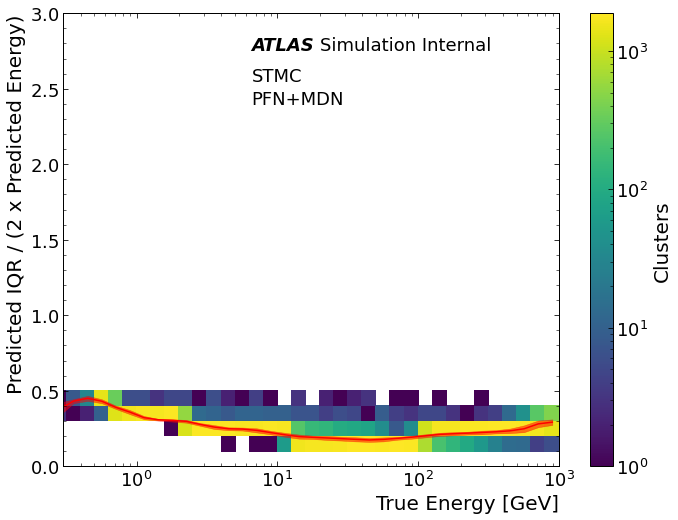

In [ ]:
xcenter, iqrOverMed_MDN_learned, learned_error = rum.responsePlot(np.exp(y_pt_test), iqr_over_median/2,
                 'mean',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlim=(0.3,1000), ylim=(0,3), baseline=False, fill_error=True,
                 step=0.1,
                 xlabel='True Energy [GeV]', ylabel='Predicted IQR / (2 x Predicted Energy)',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'STMC'},
                             {'x': 0.38, 'y': 0.8,  'text': 'PFN+MDN'}])

<Figure size 799.992x599.976 with 0 Axes>

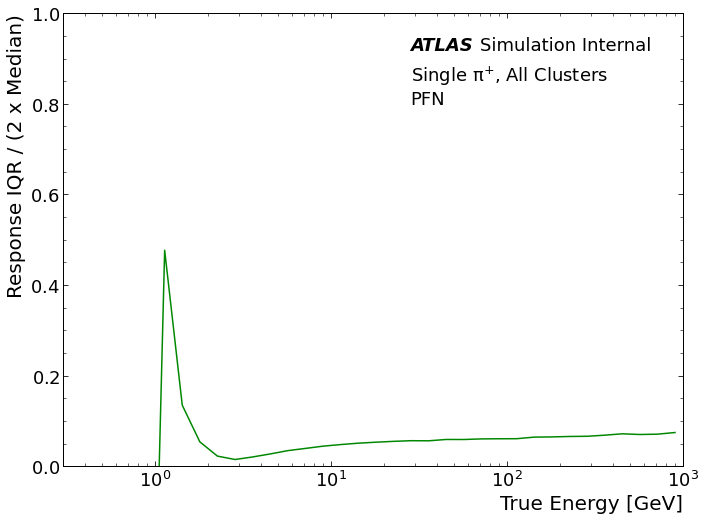

<Figure size 799.992x599.976 with 0 Axes>

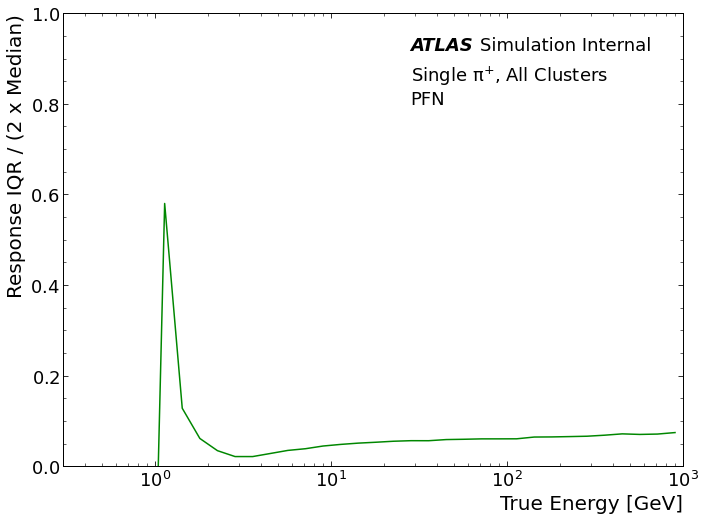

In [ ]:
import scipy.stats as stats
preds = PFN_MDN.predict(t_test)
PFN_preds = pfnT.predict(t_test)
xcenter, PFN_5f = resolutionPlot(np.exp(y_test), preds[:,0]/np.exp(y_test),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True, x_step=0.1,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN'}])
PFN_xcenter, PFN_PFN_5f = resolutionPlot(np.exp(y_test), PFN_preds[:,0]/np.exp(y_test),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True, x_step=0.1,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN'}])

<Figure size 799.992x599.976 with 0 Axes>

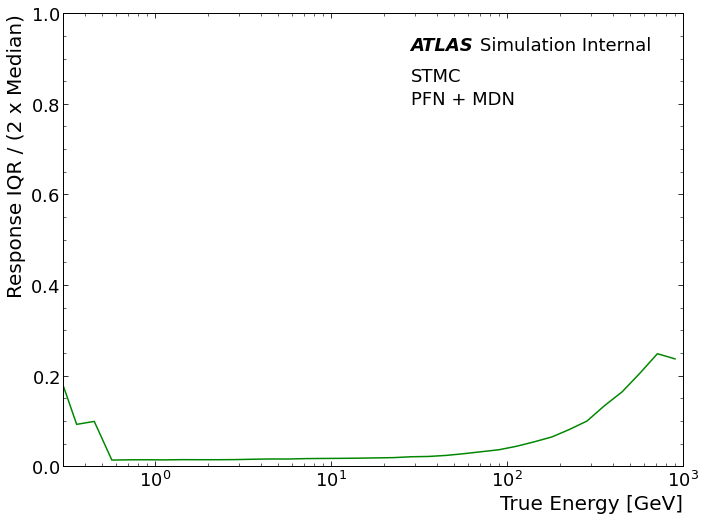

<Figure size 799.992x599.976 with 0 Axes>

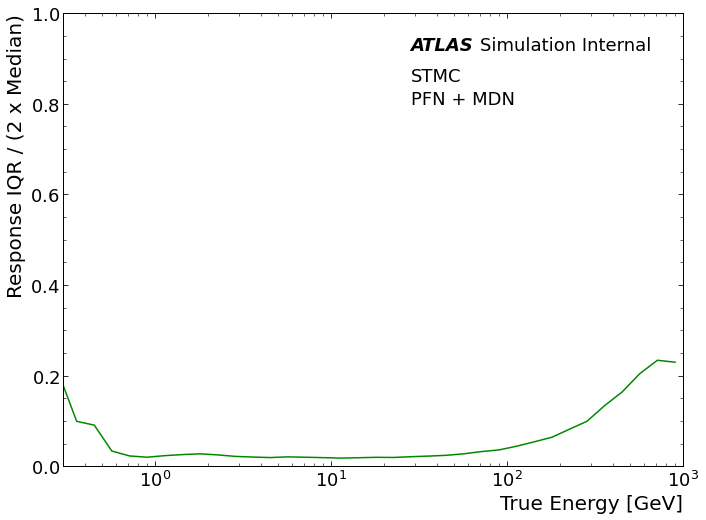

In [ ]:
xcenter, iqrPFNMDN = resolutionPlot(x=np.exp(y_test), y=np.exp(preds[:,0])/np.exp(y_test),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        x_step=0.1,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'STMC'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN + MDN'}])

PFN_xcenter, PFN_iqrPFNMDN = resolutionPlot(x=np.exp(y_test), y=np.exp(PFN_preds[:,0])/np.exp(y_test),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        x_step=0.1,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'STMC'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN + MDN'}])

<Figure size 799.992x599.976 with 0 Axes>

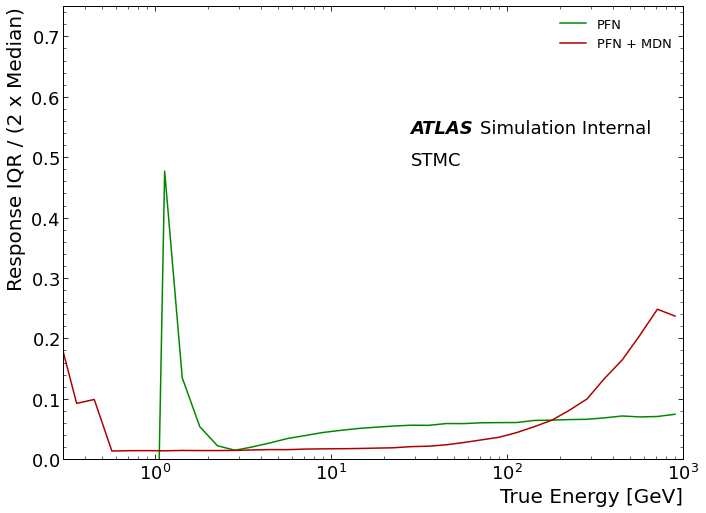

<Figure size 799.992x599.976 with 0 Axes>

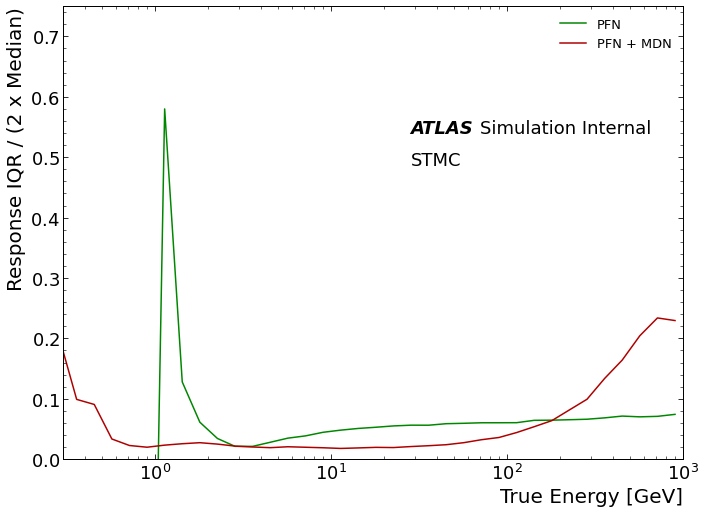

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = [PFN_5f, iqrPFNMDN],
                labels = ['PFN', 'PFN + MDN'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegLCEMB1TileBar0E1T0All.pdf",
                x_min = 0.3, y_max = .75,
                atlas_x = 0.56, atlas_y = 0.75, simulation = True,
                textlist = [{'x': 0.56, 'y': 0.65, 'text': 'STMC'}])
pu.lineOverlay(xcenter=PFN_xcenter, lines = [PFN_PFN_5f, PFN_iqrPFNMDN],
                labels = ['PFN', 'PFN + MDN'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegLCEMB1TileBar0E1T0All.pdf",
                x_min = 0.3, y_max = .75,
                atlas_x = 0.56, atlas_y = 0.75, simulation = True,
                textlist = [{'x': 0.56, 'y': 0.65, 'text': 'STMC'}])

(0.0, 1.0)

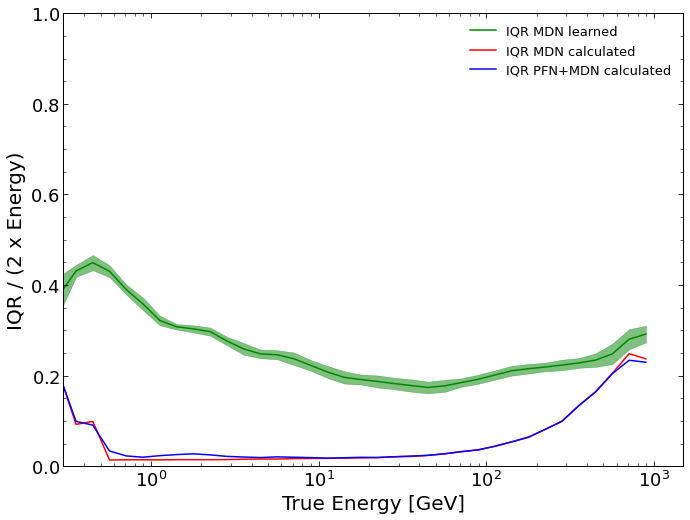

In [ ]:
upper = iqrOverMed_MDN_learned-learned_error
lower = iqrOverMed_MDN_learned+learned_error

plt.plot(xcenter, iqrOverMed_MDN_learned, label='IQR MDN learned')
#plt.errorbar(xcenter, iqrOverMed_MDN_learned, yerr=learned_error, label='IQR MDN learned')
plt.fill_between(xcenter, lower, upper, alpha=0.5, color='green')
plt.plot(xcenter, iqrPFNMDN, 'r-', label='IQR MDN calculated')
plt.plot(PFN_xcenter, PFN_iqrPFNMDN, 'b-', label='IQR PFN+MDN calculated')
#plt.plot(xcenter, PFN_5f, 'b-', label='IQR PFN')
plt.xlabel('True Energy [GeV]')
plt.ylabel('IQR / (2 x Energy)')
plt.legend()
plt.xscale('log')
plt.xlim(0.3,1500)
plt.ylim(0,1)

<Figure size 799.992x599.976 with 0 Axes>

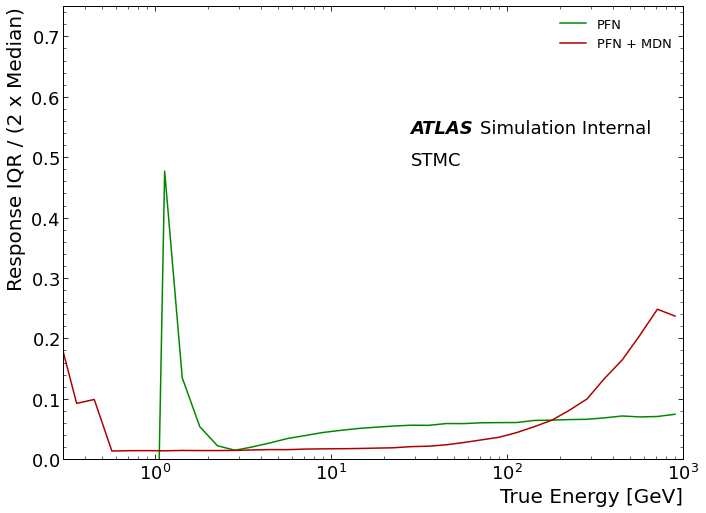

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = [PFN_5f, iqrPFNMDN],
                labels = ['PFN', 'PFN + MDN'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegLCEMB1TileBar0E1T0All.pdf",
                x_min = 0.3, y_max = .75,
                atlas_x = 0.56, atlas_y = 0.75, simulation = True,
                textlist = [{'x': 0.56, 'y': 0.65, 'text': 'STMC'}])

##Cluster Only##

In [ ]:
from sklearn.model_selection import train_test_split
#X = np.reshape(X, (np.shape(X)[0]*np.shape(X)[1], 5))
X = X[:,:,0:4]
data, TV_data, target, TV_target = train_test_split(X, Y, train_size=0.7)
test_data, val_data, test_target, val_target = train_test_split(TV_data, TV_target, train_size=0.5)

In [ ]:
def read_data(data_path):
    'read hdf5 file'
    with h5.File(data_path, 'r') as hf:
        X = hf['X'][:]
        Y = hf['Y'][:]
    return X, Y

In [ ]:
import glob
from sklearn.model_selection import train_test_split

In [ ]:
with h5.File(ext_datapath+'STMC_train.h5', 'r') as hf:
    data = hf['X'][:]
    target = hf['Y'][:]
data, TV_data, target, TV_target = train_test_split(data, target, train_size=0.7)
test_data, val_data, test_target, val_target = train_test_split(TV_data, TV_target, train_size=0.5)

In [ ]:
np.shape(X)

(431424, 6, 5)

Text(0.5, 0, 'E [GeV]')

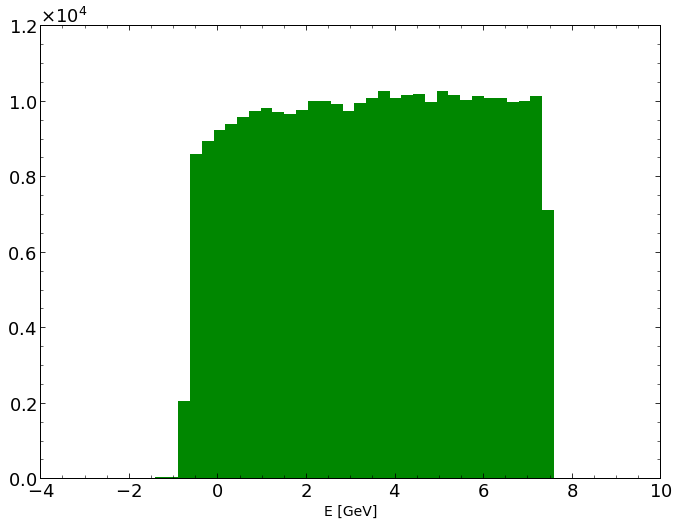

In [ ]:
plt.hist(np.log(target),bins=40)
plt.xlabel('E [GeV]', fontsize=14)

Text(0.5, 0, 'Log(E) [GeV]')

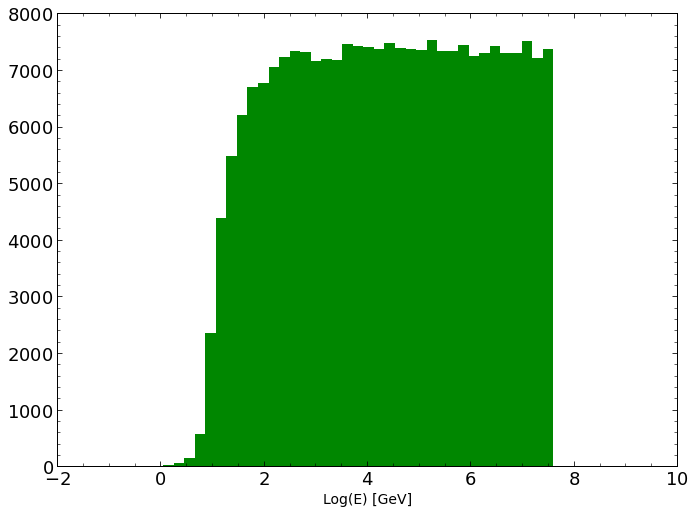

In [ ]:
plt.hist(target,bins=40)
plt.xlabel('Log(E) [GeV]', fontsize=14)

Use data generator feed input data to avoid memory issue, any one of the three here should work, carefully choose the generator batch sizes would improve the gpu usage rate.

In [ ]:
def minibatches(inputs=None, targets=None, batch_size=None, shuffle=False, aug=None):
    while True:
        assert len(inputs) == len(targets)
        if shuffle:
            indices = np.arange(len(inputs))
            np.random.shuffle(indices)
        for start_idx in range( len(inputs) - batch_size ):
            if shuffle:
                excerpt = indices[start_idx:start_idx + batch_size]
                if aug is not None:
                  (inputs[excerpt], targets[excerpt]) = next(aug.flow(inputs[excerpt],targets[excerpt], batch_size=batch_size))
            else:
                excerpt = slice(start_idx, start_idx + batch_size)
                if aug is not None:
                  (inputs[excerpt], targets[excerpt]) = next(aug.flow(inputs[excerpt],targets[excerpt], batch_size=batch_size))
            yield inputs[excerpt], targets[excerpt]

In [ ]:
def data_generator(data, targets, batch_size):
     batches = (len(data) + batch_size - 1)//batch_size
     while True:
          for i in range(batches):
               X = data[i*batch_size : (i+1)*batch_size]
               Y = targets[i*batch_size : (i+1)*batch_size]
               yield (X, Y)

In [ ]:
# write a tensorflow data input pipline to load data batches by batches to tensorflow model to avoid memory issues
def data_generator(x_data, y_data, batch_size):
    # generate a batch of data
    while True:
        for i in range(0, len(x_data), batch_size):
            yield x_data[i:i+batch_size], y_data[i:i+batch_size]


ML Model setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model
import keras.backend as Kb
!pip install energyflow
import energyflow as ef
from energyflow.archs import PFN

In [ ]:
# gpu memory usage
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 1500
batch_size = 1000

netOpt = tf.keras.optimizers.Adam(
    learning_rate=.002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)

RMS_prop = tf.keras.optimizers.RMSprop(learning_rate=0.001)

In [ ]:
# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

Kb.clear_session()

pfn = PFN(input_dim=5, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss,
          optimizer=netOpt, metrics=[])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 5)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    600         ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    10100       ['activation[0][0]']             
                                                                                              

In [ ]:
#chkpoint = tf.keras.callbacks.ModelCheckpoint(ext_modelpath + 'pfn_regressor_30f_GN.h5', monitor='val_loss', verbose=1, save_best_only=True)
t0 = t.time()
history_ct = pfn.train_on_batch(data, target, batch_size=512,
                    epochs=num_epoch,
                    verbose=1)
t1 = t.time()
print('Time to train: '+str(t1-t0)+' (s)')
print('Time to train: '+str(t1-t0)/60+' (m)')

In [ ]:
physical_gpus = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_gpus[0],True)
logical_gpus = tf.config.list_logical_devices("GPU")

In [ ]:
chkpoint = tf.keras.callbacks.ModelCheckpoint(ext_modelpath + 'pfn_regressor_30f.h5', monitor='val_loss', verbose=1, save_best_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=15, verbose=0, restore_best_weights=True)

# save history to csv, or to npy later, in order to plot comparison of multiple training runs
# history_logger = tf.keras.callbakcs.CSVLogger(ext_modelpath + 'pfn_regressor_3f_1.log', separator=',', append=True)

t0 = t.time()
history_ct = pfn.fit(data, target,
        epochs=100,
        batch_size=20,
        validation_split=0.2,
        verbose=1,
        callbacks=[chkpoint])
t1 = t.time()
print('Time to train: '+str(t1-t0)+' (s)')
print('Time to train: '+str(t1-t0)/60+' (m)')

Epoch 1/100
9882/9887 [============================>.] - ETA: 0s - loss: 18.6437
Epoch 1: val_loss improved from inf to 0.11272, saving model to /content/drive/MyDrive/ml4pion/model/pfn_regressor_30f.h5
9887/9887 [==============================] - 54s 5ms/step - loss: 18.6343 - val_loss: 0.1127
Epoch 2/100
9887/9887 [==============================] - ETA: 0s - loss: 0.0678
Epoch 2: val_loss improved from 0.11272 to 0.04294, saving model to /content/drive/MyDrive/ml4pion/model/pfn_regressor_30f.h5
9887/9887 [==============================] - 48s 5ms/step - loss: 0.0678 - val_loss: 0.0429
Epoch 3/100
9883/9887 [============================>.] - ETA: 0s - loss: 0.0237
Epoch 3: val_loss improved from 0.04294 to 0.01666, saving model to /content/drive/MyDrive/ml4pion/model/pfn_regressor_30f.h5
9887/9887 [==============================] - 47s 5ms/step - loss: 0.0237 - val_loss: 0.0167
Epoch 4/100
9886/9887 [============================>.] - ETA: 0s - loss: 0.0164
Epoch 4: val_loss improved f

TypeError: ignored

In [ ]:
np.save(ext_modelpath +'pfn_regressor_3f_nl.log.npy',history_ct.history)

In [ ]:
print('Time to train: '+str(t1-t0)+' (s)')
print('Time to train: '+str((t1-t0)/60)+' (m)')

Time to train: 4730.134009599686 (s)
Time to train: 78.83556682666143 (m)


In [ ]:
history = np.load('/content/drive/MyDrive/ml4pion/model/pfn_regressor_3f_nl.log.npy',
                     allow_pickle=True)
loss = history.item()['loss']
val_loss = history.item()['val_loss']

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


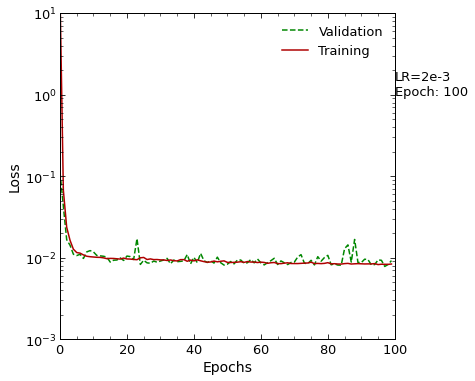

In [ ]:
fig = plt.figure(figsize=(6,6))
#plt.plot(history_ct.history['val_loss'], label="Validation",linestyle='dashed')
#plt.plot(history_ct.history['loss'], label="Training")
plt.plot(val_loss, label="Validation",linestyle='dashed')
plt.plot(loss, label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,100)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
plt.text(100, 1.5, 'LR=2e-3', fontsize=13)
plt.text(100, 1, 'Epoch: 100', fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_lossCurves_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

In [ ]:
pfn_history = load_model('/content/drive/MyDrive/ml4pion/model/pfn_regressor_30f.h5')

<Figure size 799.992x599.976 with 0 Axes>

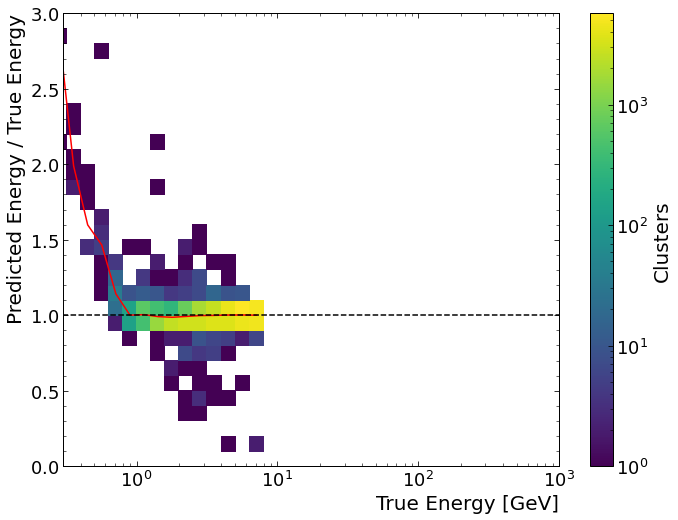

([0.11294627058970837,
  0.14219093021276402,
  0.17900777537149964,
  0.22535743732392294,
  0.2837082045838979,
  0.3571674682851675,
  0.44964720209038467,
  0.5660722890537326,
  0.7126427896022371,
  0.8971641173621403,
  1.1294627058970828,
  1.4219093021276392,
  1.7900777537149957,
  2.2535743732392284,
  2.837082045838977,
  3.5716746828516728,
  4.496472020903845,
  5.660722890537324,
  7.126427896022365,
  8.971641173621396,
  11.294627058970825,
  14.219093021276386,
  17.90077753714994,
  22.53574373239227,
  28.370820458389765,
  35.716746828516726,
  44.96472020903842,
  56.60722890537319,
  71.26427896022365,
  89.71641173621393,
  112.94627058970815,
  142.1909302127638,
  179.00777537149938,
  225.35743732392268,
  283.7082045838975,
  357.16746828516693,
  449.647202090384,
  566.0722890537315,
  712.6427896022358,
  897.1641173621388],
 array([       nan,        nan, 4.41861916, 2.98130083, 2.84521389,
        1.98846817, 1.59804797, 1.46434736, 1.14191771, 1.000415

In [ ]:
ru.responsePlot(test_target, np.reshape(pfn_history.predict(test_data), (-1,))/test_target)

In [ ]:
import scipy.stats as stats
from util import plot_util as pu

In [ ]:
Kb.clear_session()

netOpt = tf.keras.optimizers.Adam(
    learning_rate=.002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)

#PFN_mdn = ParticleFlow_MDN(num_features=5)
PFN_mdn = ParticleFlow_MDN(num_features=4)
PFN_mdn.compile(optimizer = netOpt, loss=lambda y, p_y: -p_y.log_prob(y))
PFN_mdn.summary()

Model: "PFN_MDN_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 4)]    0           []                               
                                                                                                  
 t_dist_0 (TimeDistributed)     (None, None, 100)    500         ['input[0][0]']                  
                                                                                                  
 activation_0 (Activation)      (None, None, 100)    0           ['t_dist_0[0][0]']               
                                                                                                  
 t_dist_1 (TimeDistributed)     (None, None, 100)    10100       ['activation_0[0][0]']           
                                                                                    

In [ ]:
chkpoint = tf.keras.callbacks.ModelCheckpoint(ext_modelpath + 'PFN_MDN_regressor_weight_track_only.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
PFN_mdn_log = tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/ml4pion/model/FN_mdn_track_log.log', separator=",", append=False)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=50, verbose=0, restore_best_weights=True)

t0 = t.time()

history_ct = PFN_mdn.fit(
        #PFN_mdn.fit(minibatches(data, target, batch_size=4096),
        #data_generator(data, target, 2048),
        data_generator(X, Y, 2048),
        epochs=100,
        steps_per_epoch=len(data)//2048,
        
        validation_data=data_generator(val_data, val_target, batch_size=1024),
        validation_steps=len(val_data)//1024,
        verbose=1,
        callbacks=[chkpoint, PFN_mdn_log])
t1 = t.time()

Epoch 1/100
140/147 [===========================>..] - ETA: 0s - loss: 116.3399
Epoch 1: val_loss improved from inf to 116.66080, saving model to /content/drive/MyDrive/ml4pion/model/PFN_MDN_regressor_weight_track_only.h5
147/147 [==============================] - 3s 12ms/step - loss: 116.5227 - val_loss: 116.6608
Epoch 2/100
145/147 [============================>.] - ETA: 0s - loss: 116.3928
Epoch 2: val_loss did not improve from 116.66080
147/147 [==============================] - 1s 5ms/step - loss: 116.4266 - val_loss: 116.6608
Epoch 3/100
145/147 [============================>.] - ETA: 0s - loss: 116.0412
Epoch 3: val_loss did not improve from 116.66080
147/147 [==============================] - 1s 5ms/step - loss: 116.1371 - val_loss: 116.6608
Epoch 4/100
144/147 [============================>.] - ETA: 0s - loss: 116.3871
Epoch 4: val_loss did not improve from 116.66080
147/147 [==============================] - 1s 5ms/step - loss: 116.2379 - val_loss: 116.6608
Epoch 5/100
145/14

In [ ]:
PFN_mdn.save('/content/drive/MyDrive/ml4pion/model')

OperatorNotAllowedInGraphError: ignored

In [ ]:

PFN_mdn.load_weights('/content/drive/MyDrive/ml4pion/model/PFN_MDN_regressor_weight_dg.h5')

In [ ]:
pfn_history = open('/content/drive/MyDrive/ml4pion/model/FN_mdn_log.log','r')
#loss = pfn_history.item()['loss']
#val_loss = pfn_history.item()['val_loss']
lines = pfn_history.read().splitlines()
loss_history = np.zeros((len(lines), 3))
for i in range(1,len(lines)):
  loss_history[i,:] = lines[i].split(",")
loss_history = loss_history.astype(float)

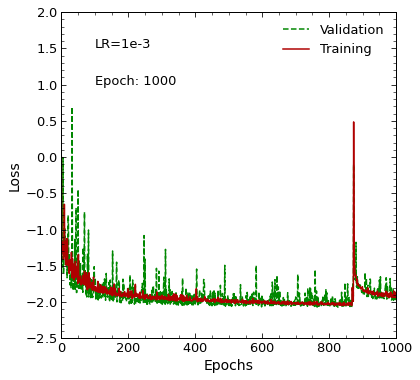

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,6))
#plt.plot(history_ct.history['val_loss'], label="Validation",linestyle='dashed')
#plt.plot(history_ct.history['loss'], label="Training")
plt.plot(loss_history[:,2], label="Validation",linestyle='dashed')
plt.plot(loss_history[:,1], label="Training")
#plt.yscale('log')
plt.ylim(-2.5,2)
plt.yticks(fontsize=13)
plt.xlim(0,1000)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
plt.text(100, 1.5, 'LR=1e-3', fontsize=13)
plt.text(100, 1, 'Epoch: 1000', fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_lossCurves_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

In [ ]:
#ru.responsePlot(test_target, pfn_history.predict(test_data))
xcenter, medDNN = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_DNN_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_E1T0_pp_profile.pdf',
                 'median',
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.46, 'y': 0.8,  'text': 'DNN'}])

In [ ]:
results = pfn_history.evaluate(test_data, test_target, verbose=2)

1545/1545 - 5s - loss: 0.0074 - 5s/epoch - 4ms/step


In [ ]:
Pm_predict = PFN_mdn.predict(test_data)

In [ ]:
print(np.shape(data))
print(np.shape(target))
print(np.shape(test_data))
print(np.shape(test_target))
print(np.shape(Pm_predict))

(304675, 6, 5)
(304675,)
(65288, 6, 5)
(65288,)
(65288, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)


<Figure size 799.992x599.976 with 0 Axes>

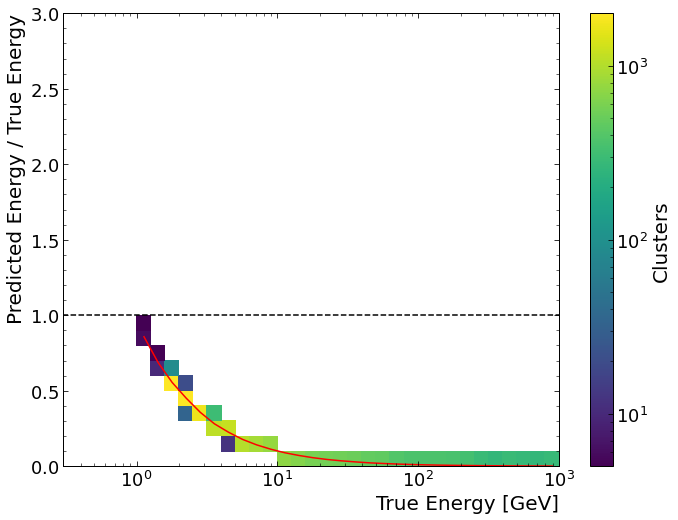

([0.11294627058970837,
  0.14219093021276402,
  0.17900777537149964,
  0.22535743732392294,
  0.2837082045838979,
  0.3571674682851675,
  0.44964720209038467,
  0.5660722890537326,
  0.7126427896022371,
  0.8971641173621403,
  1.1294627058970828,
  1.4219093021276392,
  1.7900777537149957,
  2.2535743732392284,
  2.837082045838977,
  3.5716746828516728,
  4.496472020903845,
  5.660722890537324,
  7.126427896022365,
  8.971641173621396,
  11.294627058970825,
  14.219093021276386,
  17.90077753714994,
  22.53574373239227,
  28.370820458389765,
  35.716746828516726,
  44.96472020903842,
  56.60722890537319,
  71.26427896022365,
  89.71641173621393,
  112.94627058970815,
  142.1909302127638,
  179.00777537149938,
  225.35743732392268,
  283.7082045838975,
  357.16746828516693,
  449.647202090384,
  566.0722890537315,
  712.6427896022358,
  897.1641173621388],
 array([       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        n

In [ ]:
ru.responsePlot(np.exp(test_target), np.exp(Pm_predict[:,0])/np.exp(test_target))

<Figure size 799.992x599.976 with 0 Axes>

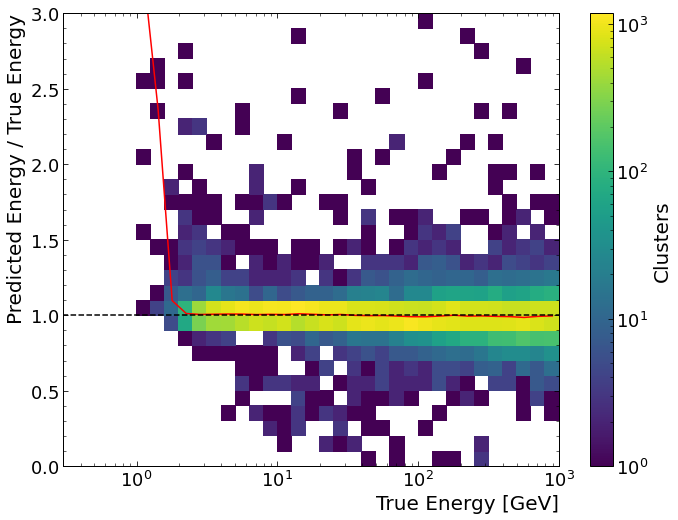

([0.11294627058970837,
  0.14219093021276402,
  0.17900777537149964,
  0.22535743732392294,
  0.2837082045838979,
  0.3571674682851675,
  0.44964720209038467,
  0.5660722890537326,
  0.7126427896022371,
  0.8971641173621403,
  1.1294627058970828,
  1.4219093021276392,
  1.7900777537149957,
  2.2535743732392284,
  2.837082045838977,
  3.5716746828516728,
  4.496472020903845,
  5.660722890537324,
  7.126427896022365,
  8.971641173621396,
  11.294627058970825,
  14.219093021276386,
  17.90077753714994,
  22.53574373239227,
  28.370820458389765,
  35.716746828516726,
  44.96472020903842,
  56.60722890537319,
  71.26427896022365,
  89.71641173621393,
  112.94627058970815,
  142.1909302127638,
  179.00777537149938,
  225.35743732392268,
  283.7082045838975,
  357.16746828516693,
  449.647202090384,
  566.0722890537315,
  712.6427896022358,
  897.1641173621388],
 array([       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        n

In [ ]:
ru.responsePlot(np.exp(test_target), np.exp(Pm_predict[:,0])/np.exp(test_target))

In [ ]:
np.shape(test_target)

(49435,)

In [ ]:
np.shape(np.reshape(pfn_history.predict(test_data), (-1,)))

(49435,)